In [2]:
import os

# Đường dẫn bạn cung cấp
dataset_path = '/kaggle/input/stockdataset/'

print(f"--- Đang kiểm tra thư mục: {dataset_path} ---")

if os.path.exists(dataset_path):
    files = os.listdir(dataset_path)
    print(f"✅ Tìm thấy thư mục! Có {len(files)} file bên trong.")
    print("Danh sách 5 file đầu tiên:", files[:5])
    
    # Kiểm tra xem có file SPY.csv hay AAPL.csv không
    if 'SPY.csv' in files or 'spy.csv' in files:
        print("✅ Đã thấy file SPY. Sẵn sàng xử lý!")
    else:
        print("⚠️ Cảnh báo: Không thấy file SPY.csv. Hãy kiểm tra lại tên file.")
else:
    print(f"❌ Lỗi: Không tìm thấy đường dẫn '{dataset_path}'")
    print("Hãy thử kiểm tra thư mục gốc: /kaggle/input")
    try:
        print(os.listdir('/kaggle/input'))
    except:
        pass

--- Đang kiểm tra thư mục: /kaggle/input/stockdataset/ ---
✅ Tìm thấy thư mục! Có 7 file bên trong.
Danh sách 5 file đầu tiên: ['MSFT.csv', 'AAPL.csv', 'DOW.csv', 'GOOG.csv', 'NVDA.csv']
✅ Đã thấy file SPY. Sẵn sàng xử lý!


In [3]:
# --- CODE ALGORITHM 1: GENERIC DATA PREPROCESSING ---
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings('ignore')

# ======================================================
# 1. CẤU HÌNH DATASET (CONTROL PANEL)
# ======================================================
stock = 'AAPL'  # <--- CHỈ CẦN ĐỔI TÊN MÃ Ở ĐÂY (VD: 'AAPL', 'BTC-USD')
BASE_DIR = '/kaggle/input/stockdataset'
cmp = 0
# ======================================================

def algorithm_1_preprocessing(ticker_symbol):
    """
    Hàm xử lý dữ liệu chuẩn (Algorithm 1 Paper).
    Input: Tên mã chứng khoán (VD: 'SPY').
    Output: train_df, test_df (DataFrame chuẩn hóa dùng chung).
    """
    print(f"\n🔄 [1/2] Đang tìm và xử lý dữ liệu cho: {ticker_symbol}...")
    
    # 1. Xây dựng đường dẫn file linh hoạt
    # Tìm file theo tên (thử cả viết hoa/thường)
    file_path = os.path.join(BASE_DIR, f"{ticker_symbol}.csv")
    if not os.path.exists(file_path):
        file_path = os.path.join(BASE_DIR, f"{ticker_symbol.lower()}.csv")
        
    if not os.path.exists(file_path):
        print(f"❌ LỖI: Không tìm thấy file CSV cho {ticker_symbol} tại {BASE_DIR}")
        return None, None, None # <--- SỬA: Trả về 3 biến None

    # 2. Load & Clean Data
    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Filter Time (2010 - Nay) theo Paper
        df = df[df.index >= '2010-01-01'].copy()
        
        # Imputation (Lấp đầy dữ liệu thiếu)
        df.interpolate(method='linear', inplace=True)
        
        # Tính Daily Returns (quan trọng cho bước tính Volatility sau này)
        df['Daily_Return'] = df['Adj Close'].pct_change()
        df.dropna(inplace=True)
        
    except Exception as e:
        print(f"❌ Lỗi xử lý dữ liệu thô: {e}")
        return None, None, None # <--- SỬA: Trả về 3 biến None
    
    # 3. Normalization (Z-score)
    scaler = StandardScaler()
    cols_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    
    # Kiểm tra cột tồn tại
    valid_cols = [c for c in cols_to_scale if c in df.columns]
    if len(valid_cols) < len(cols_to_scale):
        print(f"⚠️ Cảnh báo: Thiếu cột dữ liệu. Chỉ xử lý: {valid_cols}")

    df_scaled = df.copy()
    df_scaled[valid_cols] = scaler.fit_transform(df[valid_cols])

    # --- [THÊM MỚI] TARGET SCALER ---
    # Chỉ fit riêng cho cột Adj Close để dùng cho Inverse Transform sau này
    target_scaler = StandardScaler()
    target_scaler.fit(df[['Adj Close']])
    # --------------------------------
    
    # Đổi tên cột (Thêm suffix _Norm)
    df_scaled.columns = [f"{c}_Norm" if c in valid_cols else c for c in df_scaled.columns]
    
    # 4. Seasonal Decomposition (Phân rã chuỗi thời gian)
    # 
    try:
        # period=252 (1 năm trading)
        res = seasonal_decompose(df_scaled['Adj Close_Norm'], model='additive', period=252)
        df_scaled['Trend'] = res.trend
        df_scaled['Seasonal'] = res.seasonal
        df_scaled['Residual'] = res.resid
        df_scaled.dropna(inplace=True)
    except Exception as e:
        print(f"⚠️ Không thể phân rã mùa vụ (Dữ liệu < 2 năm?): {e}")
        df_scaled['Trend'] = df_scaled['Adj Close_Norm'] # Fallback
        df_scaled['Seasonal'] = 0
        df_scaled['Residual'] = 0

    # 5. Split Train/Test (80/20)
    split_idx = int(len(df_scaled) * 0.8)
    train = df_scaled.iloc[:split_idx]
    test = df_scaled.iloc[split_idx:]
    
    print(f"✅ [2/2] Hoàn tất! Dataset '{ticker_symbol}' sẵn sàng.")
    print(f"   Train shape: {train.shape}")
    print(f"   Test shape:  {test.shape}")
    
    # <--- SỬA: Trả về thêm target_scaler
    return train, test, target_scaler

# --- MAIN EXECUTION (GENERIC) ---
# Biến toàn cục CHUẨN: train_df, test_df, target_scaler
# Các cell sau này chỉ cần gọi train_df, test_df là chạy được.
# <--- SỬA: Hứng thêm target_scaler
train_df, test_df, target_scaler = algorithm_1_preprocessing(stock)

# Validation check
if train_df is not None:
    print(f"\n--- Kiểm tra 3 dòng đầu của {stock} (Train Set) ---")
    print(train_df[['Adj Close_Norm', 'Trend', 'Daily_Return']].head(3))
    print(f"\n--- Kiểm tra Target Scaler ---")
    print(f"Mean (USD): {target_scaler.mean_[0]:.2f}")
else:
    print("❌ Dừng chương trình: Không có dữ liệu đầu vào.")


🔄 [1/2] Đang tìm và xử lý dữ liệu cho: AAPL...
✅ [2/2] Hoàn tất! Dataset 'AAPL' sẵn sàng.
   Train shape: (2588, 10)
   Test shape:  (648, 10)

--- Kiểm tra 3 dòng đầu của AAPL (Train Set) ---
            Adj Close_Norm     Trend  Daily_Return
Date                                              
2010-07-07       -0.895188 -0.894154      0.040381
2010-07-08       -0.895510 -0.893890     -0.002242
2010-07-09       -0.894661 -0.893619      0.005928

--- Kiểm tra Target Scaler ---
Mean (USD): 56.66



🌲 BẮT ĐẦU RANDOM FOREST CHO: AAPL...
   Input Shape: (2508, 800) (Samples, Features * Lookback)
   👉 Training Paper RF (Lambda=-0.002)...
   ✅ Đã lưu Train Predictions: rfr_train_predictions (2508 mẫu)

📊 --- KẾT QUẢ PAPER RF (Comparison Mode OFF) ---
   RMSE: 0.3782
   R2 Score: -0.8391
   Directional Accuracy: 56.44%


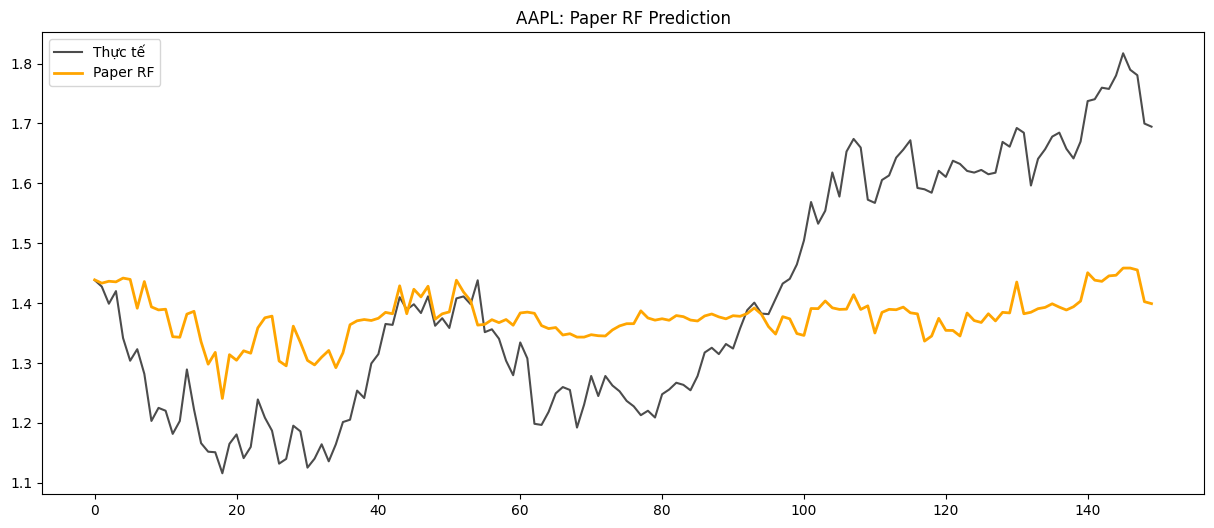

In [4]:
# --- CODE MODEL 3: RANDOM FOREST (PAPER vs STANDARD) - WITH TRAIN PREDICTIONS ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CẤU HÌNH RANDOM FOREST ---
RF_CONFIG = {
    'LOOK_BACK': 80,       # Cửa sổ trượt
    'N_ESTIMATORS': 100,   # Số lượng cây (B)
    'LAMBDA': -0.002,      # Hệ số phạt (Lambda)
    'N_JOBS': -1,          # Dùng full CPU
    'RANDOM_STATE': 42
}

# --- 2. CÁC CLASS VÀ HÀM HỖ TRỢ ---

class PaperRandomForest(RandomForestRegressor):
    """
    Random Forest tùy chỉnh theo phương trình (1) của bài báo.
    Công thức: Prediction = Standard_RF_Prediction - (lambda * B)
    """
    def __init__(self, n_estimators=100, penalty_lambda=0.0, **kwargs):
        super().__init__(n_estimators=n_estimators, **kwargs)
        self.penalty_lambda = penalty_lambda
        self.B = n_estimators 
        
    def predict(self, X):
        base_pred = super().predict(X)
        penalty = self.penalty_lambda * self.B
        return base_pred - penalty

def create_flattened_dataset(dataset_df, look_back=60):
    """Chuyển đổi Time Series (3D/Sequences) thành dạng phẳng (2D) cho RF"""
    data = dataset_df.values
    X, y = [], []
    target_idx = 0 
    
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back), :]
        X.append(window.flatten())
        y.append(data[i + look_back, target_idx])
        
    return np.array(X), np.array(y)

# --- 3. HÀM THỰC THI CHÍNH (GENERIC & CONDITIONAL) ---
def run_rf_comparison(train_data, test_data, ticker_name="Unknown"):
    print(f"\n🌲 BẮT ĐẦU RANDOM FOREST CHO: {ticker_name}...")
    
    # 1. Chuẩn bị dữ liệu
    look_back = RF_CONFIG['LOOK_BACK']
    X_train, y_train = create_flattened_dataset(train_data, look_back)
    X_test, y_test = create_flattened_dataset(test_data, look_back)
    
    print(f"   Input Shape: {X_train.shape} (Samples, Features * Lookback)")

    # 2. Train Paper Random Forest (LUÔN LUÔN CHẠY)
    print(f"   👉 Training Paper RF (Lambda={RF_CONFIG['LAMBDA']})...")
    paper_rf = PaperRandomForest(
        n_estimators=RF_CONFIG['N_ESTIMATORS'],
        penalty_lambda=RF_CONFIG['LAMBDA'],
        n_jobs=RF_CONFIG['N_JOBS'],
        random_state=RF_CONFIG['RANDOM_STATE']
    )
    paper_rf.fit(X_train, y_train)
    
    # --- QUAN TRỌNG: LƯU KẾT QUẢ TRAIN & TEST ---
    global rfr_predictions, rfr_train_predictions, paper_rf_model
    
    # A. Dự báo trên tập Train (Cho In-Sample Evaluation)
    rfr_train_predictions = paper_rf.predict(X_train)
    print(f"   ✅ Đã lưu Train Predictions: rfr_train_predictions ({len(rfr_train_predictions)} mẫu)")
    
    # B. Dự báo trên tập Test (Cho Out-of-Sample Evaluation)
    y_pred_paper = paper_rf.predict(X_test)
    rfr_predictions = y_pred_paper 
    
    # C. Lưu model object để dùng lại nếu cần
    paper_rf_model = paper_rf
    
    # 3. Tính toán và Hiển thị
    def get_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100
        return rmse, r2, dir_acc

    rmse_p, r2_p, da_p = get_metrics(y_test, y_pred_paper)

    # Xử lý logic so sánh (Dựa trên biến cmp)
    if 'cmp' in globals() and cmp == 1:
        # --- CHẾ ĐỘ SO SÁNH: CHẠY THÊM STANDARD RF ---
        print(f"   👉 Training Standard RF (Pure Sklearn) [Comparison Mode ON]...")
        std_rf = RandomForestRegressor(
            n_estimators=RF_CONFIG['N_ESTIMATORS'],
            n_jobs=RF_CONFIG['N_JOBS'],
            random_state=RF_CONFIG['RANDOM_STATE']
        )
        std_rf.fit(X_train, y_train)
        y_pred_std = std_rf.predict(X_test)
        
        rmse_s, r2_s, da_s = get_metrics(y_test, y_pred_std)
        
        # In bảng so sánh
        print("\n📊 --- BẢNG SO SÁNH HIỆU SUẤT ---")
        print(f"{'Metric':<10} | {'PAPER RF':<15} | {'STANDARD RF':<15}")
        print("-" * 45)
        print(f"{'RMSE':<10} | {rmse_p:.4f}{' '*9} | {rmse_s:.4f}")
        print(f"{'R2':<10} | {r2_p:.4f}{' '*9} | {r2_s:.4f}")
        print(f"{'Dir Acc':<10} | {da_p:.2f}%{' '*8} | {da_s:.2f}%")
        
        if rmse_p < rmse_s:
            print("\n✅ Paper RF tốt hơn (RMSE thấp hơn).")
        else:
            print("\n⚠️ Standard RF tốt hơn (Có thể Lambda chưa tối ưu).")
            
    else:
        # --- CHẾ ĐỘ NHANH: CHỈ IN KẾT QUẢ PAPER RF ---
        print("\n📊 --- KẾT QUẢ PAPER RF (Comparison Mode OFF) ---")
        print(f"   RMSE: {rmse_p:.4f}")
        print(f"   R2 Score: {r2_p:.4f}")
        print(f"   Directional Accuracy: {da_p:.2f}%")

    # 4. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    limit = 150
    plt.plot(y_test[:limit], label='Thực tế', color='black', alpha=0.7)
    plt.plot(y_pred_paper[:limit], label='Paper RF', color='orange', linewidth=2)
    
    if 'cmp' in globals() and cmp == 1:
        plt.plot(y_pred_std[:limit], label='Standard RF', color='blue', linestyle='-.', alpha=0.5)
        plt.title(f'{ticker_name}: Paper RF vs Standard RF (Comparison)')
    else:
        plt.title(f'{ticker_name}: Paper RF Prediction')
        
    plt.legend()
    plt.show()

# --- 4. EXECUTION (MODULAR) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    run_rf_comparison(train_df, test_df, target_stock)
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu train_df/test_df. Vui lòng chạy Algorithm 1 trước.")


🚀 BẮT ĐẦU ROLLING WINDOW LSTM CHO: AAPL...
   Tổng mẫu: 3176 | Window: 1260 | Step: 20


Training Progress:   0%|          | 0/1916 [00:00<?, ?it/s]

✅ ĐÃ TẠO BIẾN TOÀN CỤC:
   🔹 lstm_train_predictions: 2528 mẫu
   🔹 lstm_predictions:       648 mẫu

📊 --- KẾT QUẢ LSTM: AAPL ---
   RMSE: 0.0699
   R2 Score: 0.9474
   Directional Accuracy: 73.11%


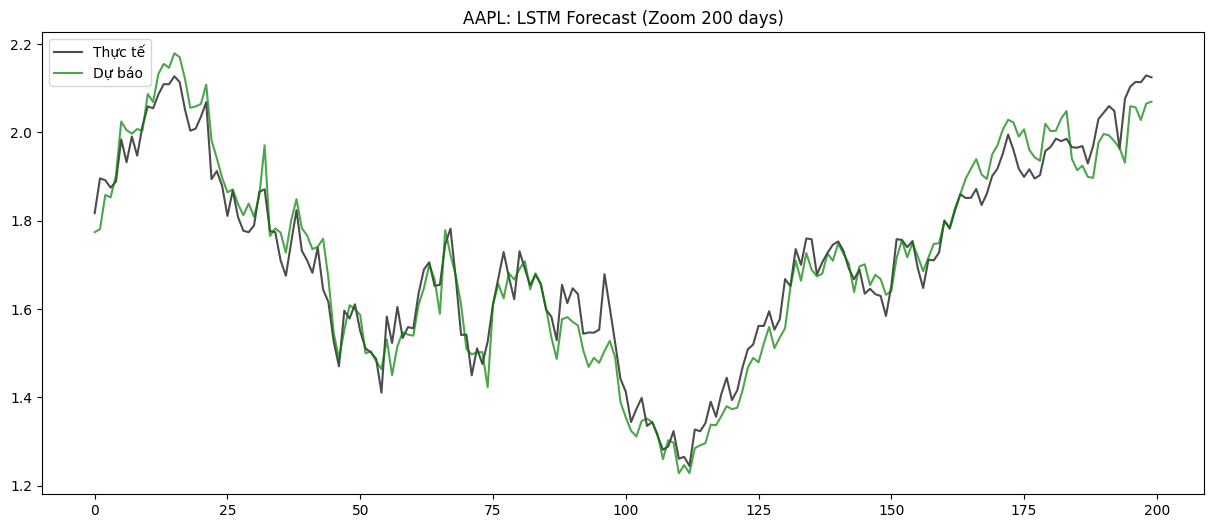

In [11]:
# --- CODE MODEL 2: LSTM ROLLING WINDOW (GENERIC & OPTIMIZED SPEED) ---
import os
import logging
import warnings

# 1. TỐI ƯU HÓA: Single GPU (Nhanh nhất cho loop liên tục)
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

# ======================================================
# CẤU HÌNH LSTM (GLOBAL CONFIG)
# ======================================================
LSTM_CONFIG = {
    'LOOK_BACK': 60,           # 60 ngày quá khứ
    'TRAIN_WINDOW': 252 * 5,   # 5 năm training
    'PREDICT_HORIZON': 20,     # Retrain sau mỗi 1 tháng
    'EPOCHS': 5,               # 5 epoch là đủ vì ta dùng Incremental Learning
    'BATCH_SIZE': 32,
    'UNITS': 50,               
    'DROPOUT': 0.2
}

# --- HÀM HỖ TRỢ ---
def create_dataset_3d(dataset, look_back=60):
    """Chuyển đổi dữ liệu sang 3D cho LSTM"""
    X, y = [], []
    target_idx = 0 
    # Đảm bảo dataset là numpy array
    data = dataset.values if hasattr(dataset, 'values') else dataset
    
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, target_idx])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    """Xây dựng mạng LSTM"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=LSTM_CONFIG['UNITS'], return_sequences=True))
    model.add(Dropout(LSTM_CONFIG['DROPOUT']))
    model.add(LSTM(units=LSTM_CONFIG['UNITS'], return_sequences=False))
    model.add(Dropout(LSTM_CONFIG['DROPOUT']))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# --- HÀM THỰC THI (INCREMENTAL LEARNING) ---
def run_rolling_window_lstm(train_data, test_data, ticker_symbol="Unknown"):
    print(f"\n🚀 BẮT ĐẦU ROLLING WINDOW LSTM CHO: {ticker_symbol}...")
    
    # 1. Gộp dữ liệu train/test thành 1 dòng thời gian
    full_df = pd.concat([train_data, test_data])
    data_values = full_df.values
    
    # 2. Tạo dataset
    X_all, y_all = create_dataset_3d(data_values, LSTM_CONFIG['LOOK_BACK'])
    total_samples = len(X_all)
    
    train_window = LSTM_CONFIG['TRAIN_WINDOW']
    step_size = LSTM_CONFIG['PREDICT_HORIZON']
    start_index = train_window 
    
    all_preds = []
    all_actuals = []
    # [NEW] Biến lưu dự báo của cửa sổ khởi tạo
    initial_train_preds = None 
    
    print(f"   Tổng mẫu: {total_samples} | Window: {train_window} | Step: {step_size}")
    pbar = tqdm(total=total_samples - start_index, desc="Training Progress")
    
    # --- TỐI ƯU HÓA TỐC ĐỘ ---
    tf.keras.backend.clear_session()

    # Khởi tạo model 1 lần duy nhất bên ngoài vòng lặp
    model = build_lstm_model((LSTM_CONFIG['LOOK_BACK'], X_all.shape[2]))
    
    current_idx = start_index
    
    while current_idx < total_samples:
        # A. Cắt dữ liệu
        train_start = current_idx - train_window
        train_end = current_idx
        X_train = X_all[train_start:train_end]
        y_train = y_all[train_start:train_end]
        
        test_end = min(current_idx + step_size, total_samples)
        X_test = X_all[current_idx:test_end]
        y_test = y_all[current_idx:test_end]
        
        if len(X_test) == 0: break
            
        # B. Retrain (Incremental - Học nối tiếp)
        model.fit(X_train, y_train, 
                  epochs=LSTM_CONFIG['EPOCHS'], 
                  batch_size=LSTM_CONFIG['BATCH_SIZE'], 
                  verbose=0)
        
        # [NEW] --- CAPTURE INITIAL IN-SAMPLE ---
        # Ngay lần đầu tiên (khi model vừa học xong cửa sổ đầu), ta dự báo lại chính cửa sổ đó
        # để lấy train_predictions cho đoạn dữ liệu khởi đầu này.
        if current_idx == start_index:
             initial_train_preds = model.predict(X_train, verbose=0).flatten()

        # C. Predict
        preds = model.predict(X_test, verbose=0)
        all_preds.extend(preds.flatten())
        all_actuals.extend(y_test)
        
        # D. Update
        processed = len(y_test)
        current_idx += processed
        pbar.update(processed)
        
    pbar.close()
    
    # Trả về thêm initial_train_preds
    return np.array(all_actuals), np.array(all_preds), initial_train_preds

def evaluate_lstm_results(y_true, y_pred, ticker_symbol):
    print(f"\n📊 --- KẾT QUẢ LSTM: {ticker_symbol} ---")
    
    # Cắt độ dài cho bằng nhau để tính metric
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[-min_len:]
    y_pred = y_pred[-min_len:]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100
    
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R2 Score: {r2:.4f}")
    print(f"   Directional Accuracy: {dir_acc:.2f}%")
    
    # Vẽ biểu đồ Zoom
    plt.figure(figsize=(15, 6))
    limit = 200
    if len(y_true) > limit:
        plt.plot(y_true[-limit:], label='Thực tế', color='black', alpha=0.7)
        plt.plot(y_pred[-limit:], label='Dự báo', color='green', alpha=0.7)
        plt.title(f'{ticker_symbol}: LSTM Forecast (Zoom {limit} days)')
    else:
        plt.plot(y_true, label='Thực tế')
        plt.plot(y_pred, label='Dự báo')
    plt.legend()
    plt.show()

# --- EXECUTION (GENERIC & SPLIT) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    # 1. Chạy hàm (nhận 3 giá trị trả về)
    y_true_roll, y_pred_roll, initial_preds = run_rolling_window_lstm(train_df, test_df, target_stock)
    
    # 2. Ghép nối để tạo Full Timeline
    if initial_preds is not None:
        full_preds = np.concatenate([initial_preds, y_pred_roll])
    else:
        full_preds = y_pred_roll
        
    # 3. CẮT RA THÀNH TRAIN/TEST PREDICTIONS DỰA TRÊN train_df CỦA BẠN
    # Output của LSTM bị thụt vào 'look_back' dòng so với dữ liệu gốc
    look_back = LSTM_CONFIG['LOOK_BACK']
    split_idx = len(train_df) - look_back
    
    # Lưu biến toàn cục
    global lstm_train_predictions, lstm_predictions
    
    if split_idx < len(full_preds):
        lstm_train_predictions = full_preds[:split_idx]
        lstm_predictions = full_preds[split_idx:]
    else:
        # Trường hợp hiếm: Train Window lớn hơn cả tập Train
        lstm_train_predictions = full_preds
        lstm_predictions = np.array([])
        
    print(f"✅ ĐÃ TẠO BIẾN TOÀN CỤC:")
    print(f"   🔹 lstm_train_predictions: {len(lstm_train_predictions)} mẫu")
    print(f"   🔹 lstm_predictions:       {len(lstm_predictions)} mẫu")

    # Đánh giá trên tập Test (dùng lstm_predictions vừa cắt)
    evaluate_lstm_results(y_true_roll[-len(lstm_predictions):], lstm_predictions, target_stock)
    
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu. Hãy chạy Algorithm 1 trước.")


🚀 [CMP=0] KẾT QUẢ ADAPTIVE LSTM (ROLLING) CHO: AAPL
   (Đã bỏ qua Static Model để tiết kiệm thời gian)
----------------------------------------
   RMSE: 0.0991
   MAE: 0.0759
   Directional Accuracy: 68.31%


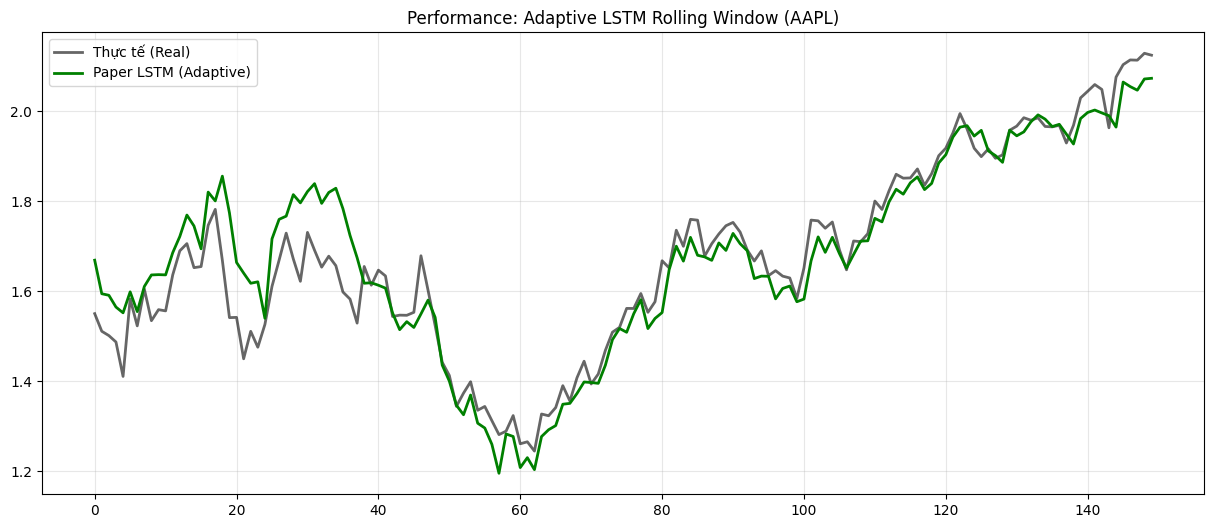

In [8]:
# --- CODE COMPARISON: STATIC LSTM vs ADAPTIVE LSTM (MODULAR & CONDITIONAL) ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def run_static_lstm_comparison(train_data, test_data, adaptive_preds, ticker_symbol="Unknown"):
    """
    So sánh hiệu quả giữa Static Model và Adaptive Model.
    Nếu cmp=0: Chỉ đánh giá Adaptive Model (Bỏ qua Static để tiết kiệm thời gian).
    """
    
    # 1. Chuẩn bị dữ liệu Ground Truth (Thực tế) từ tập Test
    # Ta luôn cần cái này để chấm điểm, dù có chạy Static hay không
    look_back = LSTM_CONFIG['LOOK_BACK']
    
    # Chỉ cần tạo X_test, y_test để lấy Ground Truth
    # (X_test chỉ dùng nếu chạy Static, y_test dùng để so khớp)
    X_test_std, y_test_std = create_dataset_3d(test_data.values, look_back)
    
    # 2. ĐỒNG BỘ HÓA DỮ LIỆU (ALIGNMENT) CHO ADAPTIVE MODEL
    # Cắt lấy đoạn giao nhau cuối cùng giữa Thực tế và Dự báo Rolling
    min_len = min(len(y_test_std), len(adaptive_preds))
    
    y_true_final = y_test_std[-min_len:]       # Thực tế
    y_pred_adap_final = adaptive_preds[-min_len:] # Adaptive Prediction
    
    # Hàm tính metrics nội bộ
    def get_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100
        return rmse, mae, dir_acc

    # Tính điểm cho Adaptive Model (Luôn chạy)
    rmse_a, mae_a, acc_a = get_metrics(y_true_final, y_pred_adap_final)

    # 3. XỬ LÝ LOGIC SO SÁNH (DỰA TRÊN BIẾN cmp)
    if cmp == 1:
        print(f"\n🛑 [CMP=1] ĐANG CHẠY STANDARD LSTM (STATIC MODE) CHO: {ticker_symbol}...")
        
        # A. Chuẩn bị dữ liệu Train cho Static
        X_train_std, y_train_std = create_dataset_3d(train_data.values, look_back)
        
        # B. Xây dựng và Train Model
        tf.keras.backend.clear_session()
        model_std = build_lstm_model((X_train_std.shape[1], X_train_std.shape[2]))
        
        print("   Training Static Model (20 Epochs)...")
        model_std.fit(X_train_std, y_train_std, 
                      epochs=20, 
                      batch_size=LSTM_CONFIG['BATCH_SIZE'], 
                      verbose=0)
        
        # C. Dự báo
        print("   Predicting on Test set...")
        y_pred_static = model_std.predict(X_test_std, verbose=0).flatten()
        
        # D. Cắt dữ liệu Static cho khớp độ dài
        y_pred_stat_final = y_pred_static[-min_len:]
        
        # E. Tính điểm Static
        rmse_s, mae_s, acc_s = get_metrics(y_true_final, y_pred_stat_final)
        
        # F. IN BẢNG SO SÁNH
        print(f"\n{'='*70}")
        print(f"{'METRIC':<15} | {'STANDARD (STATIC)':<22} | {'PAPER (ADAPTIVE)':<22}")
        print(f"{'-'*70}")
        
        def mark(val1, val2, higher_better=False):
            better = (val1 > val2) if higher_better else (val1 < val2)
            return '✅' if better else ''

        print(f"{'RMSE':<15} | {rmse_s:.4f} {mark(rmse_s, rmse_a)}{' '*14} | {rmse_a:.4f} {mark(rmse_a, rmse_s)}")
        print(f"{'MAE':<15} | {mae_s:.4f} {mark(mae_s, mae_a)}{' '*14} | {mae_a:.4f} {mark(mae_a, mae_s)}")
        print(f"{'Dir Acc':<15} | {acc_s:.2f}% {mark(acc_s, acc_a, True)}{' '*13} | {acc_a:.2f}% {mark(acc_a, acc_s, True)}")
        print(f"{'='*70}")
        
        if rmse_a < rmse_s:
            print("💡 KẾT LUẬN: Cơ chế Adaptive (Paper) HIỆU QUẢ HƠN Static!")
        else:
            print("💡 KẾT LUẬN: Static đang tốt hơn (Cần xem lại tham số Rolling).")
            
    else:
        # --- CHẾ ĐỘ NHANH (CMP=0) ---
        print(f"\n🚀 [CMP=0] KẾT QUẢ ADAPTIVE LSTM (ROLLING) CHO: {ticker_symbol}")
        print(f"   (Đã bỏ qua Static Model để tiết kiệm thời gian)")
        print(f"{'-'*40}")
        print(f"   RMSE: {rmse_a:.4f}")
        print(f"   MAE: {mae_a:.4f}")
        print(f"   Directional Accuracy: {acc_a:.2f}%")

    # 4. VẼ BIỂU ĐỒ
    plt.figure(figsize=(15, 6))
    zoom = 150 # Zoom 150 ngày cuối
    
    # Luôn vẽ Thực tế và Adaptive
    plt.plot(y_true_final[-zoom:], label='Thực tế (Real)', color='black', linewidth=2, alpha=0.6)
    plt.plot(y_pred_adap_final[-zoom:], label='Paper LSTM (Adaptive)', color='green', linewidth=2)
    
    # Chỉ vẽ Static nếu có chạy so sánh
    if cmp == 1:
        plt.plot(y_pred_stat_final[-zoom:], label='Standard LSTM (Static)', color='red', linestyle='--', alpha=0.8)
        plt.title(f'Comparison: Static vs Adaptive LSTM ({ticker_symbol})')
    else:
        plt.title(f'Performance: Adaptive LSTM Rolling Window ({ticker_symbol})')
        
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- EXECUTION (MODULAR) ---
# Yêu cầu: Biến lstm_predictions (từ Cell 2) phải tồn tại
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and 'lstm_predictions' in globals():
    run_static_lstm_comparison(train_df, test_df, lstm_predictions, target_stock)
else:
    print("⚠️ Lỗi: Thiếu dữ liệu. Hãy chạy Algorithm 1 và LSTM Rolling trước.")


📉 ĐANG HUẤN LUYỆN LINEAR REGRESSION CHO: AAPL...
   Input Shape: (2528, 600)
   👉 Đang tạo dự báo Train & Test...

📊 --- KẾT QUẢ LINEAR REGRESSION ---
   RMSE: 0.0453
   R2 Score: 0.9736
   Directional Accuracy: 66.44%


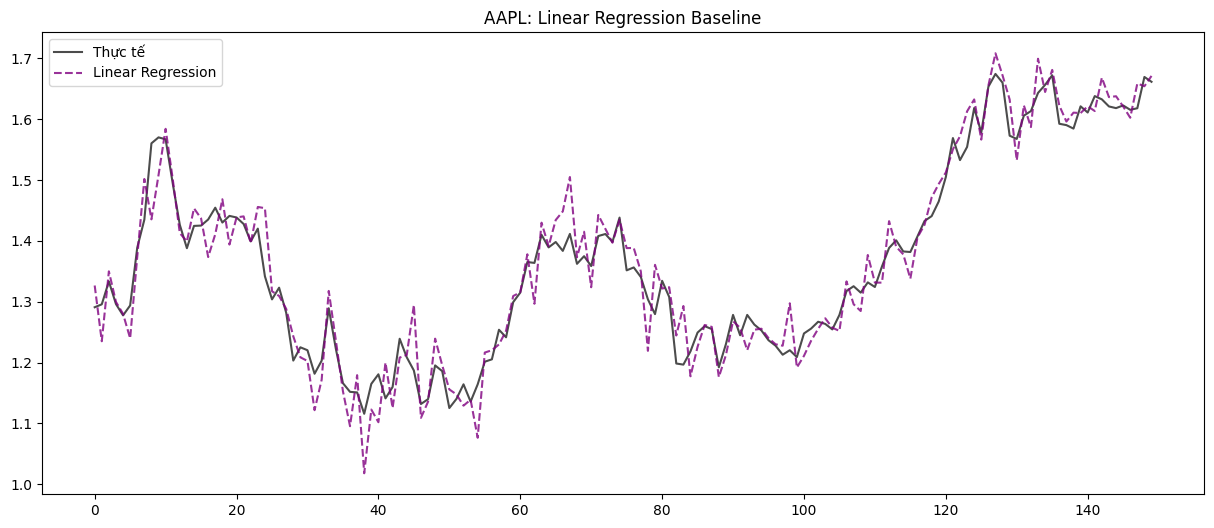

✅ Đã lưu kết quả Linear Regression.
   - lr_train_predictions: 2528 mẫu
   - lr_predictions:       588 mẫu (Test)


In [12]:
# --- CODE MODEL 4: LINEAR REGRESSION (BASELINE) - STANDARDIZED ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ======================================================
# CẤU HÌNH
# ======================================================
LR_CONFIG = {
    'LOOK_BACK': 60
}

# --- HÀM HỖ TRỢ ---
def create_flattened_dataset_lr(dataset_df, look_back=60):
    """Chuyển đổi dữ liệu sang dạng phẳng (2D) cho LR"""
    if hasattr(dataset_df, 'values'): data = dataset_df.values
    else: data = dataset_df
        
    X, y = [], []
    target_idx = 0 
    
    if len(data) <= look_back:
        return np.array([]), np.array([])
        
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back), :]
        X.append(window.flatten())
        y.append(data[i + look_back, target_idx])
    return np.array(X), np.array(y)

# --- HÀM THỰC THI CHÍNH ---
def run_linear_regression(train_data, test_data, ticker_symbol="Unknown"):
    print(f"\n📉 ĐANG HUẤN LUYỆN LINEAR REGRESSION CHO: {ticker_symbol}...")
    
    # 1. Chuẩn bị dữ liệu
    look_back = LR_CONFIG['LOOK_BACK']
    X_train, y_train = create_flattened_dataset_lr(train_data, look_back)
    X_test, y_test = create_flattened_dataset_lr(test_data, look_back)
    
    print(f"   Input Shape: {X_train.shape}")
    
    # 2. Khởi tạo và Train
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # [NEW] Lưu model object ra biến toàn cục
    global lr_model_object
    lr_model_object = lr_model
    
    # 3. Dự báo (CHO CẢ TRAIN VÀ TEST)
    print("   👉 Đang tạo dự báo Train & Test...")
    y_pred_train = lr_model.predict(X_train)
    y_pred_test = lr_model.predict(X_test)
    
    # 4. Đánh giá (Trên tập Test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    
    # Tính Directional Accuracy
    diff_true = np.diff(y_test)
    diff_pred = np.diff(y_pred_test)
    dir_acc = np.mean(np.sign(diff_true) == np.sign(diff_pred)) * 100 if len(diff_true) > 0 else 0
    
    print(f"\n📊 --- KẾT QUẢ LINEAR REGRESSION ---")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R2 Score: {r2:.4f}")
    print(f"   Directional Accuracy: {dir_acc:.2f}%")
    
    # 5. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    limit = 150
    plt.plot(y_test[:limit], label='Thực tế', color='black', alpha=0.7)
    plt.plot(y_pred_test[:limit], label='Linear Regression', color='purple', linestyle='--', alpha=0.8)
    plt.title(f'{ticker_symbol}: Linear Regression Baseline')
    plt.legend()
    plt.show()
    
    # Trả về đầy đủ
    return y_pred_train, y_train, y_pred_test, y_test

# --- EXECUTION & GLOBAL SAVING ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    # Chạy model
    lr_train_pred, lr_train_act, lr_test_pred, lr_test_act = run_linear_regression(train_df, test_df, target_stock)
    
    # --- QUAN TRỌNG: LƯU GLOBAL BIẾN TRAIN/TEST (CHUẨN HÓA TÊN) ---
    global lr_train_predictions, lr_predictions
    
    lr_train_predictions = lr_train_pred
    lr_predictions = lr_test_pred  # Đổi tên từ lr_test_predictions -> lr_predictions
    
    print(f"✅ Đã lưu kết quả Linear Regression.")
    print(f"   - lr_train_predictions: {len(lr_train_predictions)} mẫu")
    print(f"   - lr_predictions:       {len(lr_predictions)} mẫu (Test)")
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu train_df/test_df.")


🐢 ĐANG HUẤN LUYỆN SVR (Support Vector Regression) CHO: AAPL...
   Input Shape: (2528, 600)
   👉 Đang fitting model (có thể mất chút thời gian)...
   👉 Đang tạo dự báo Train & Test...

📊 --- KẾT QUẢ SVR (Tuned) ---
   RMSE: 0.1855
   R2 Score: 0.5573
   Directional Accuracy: 66.27%


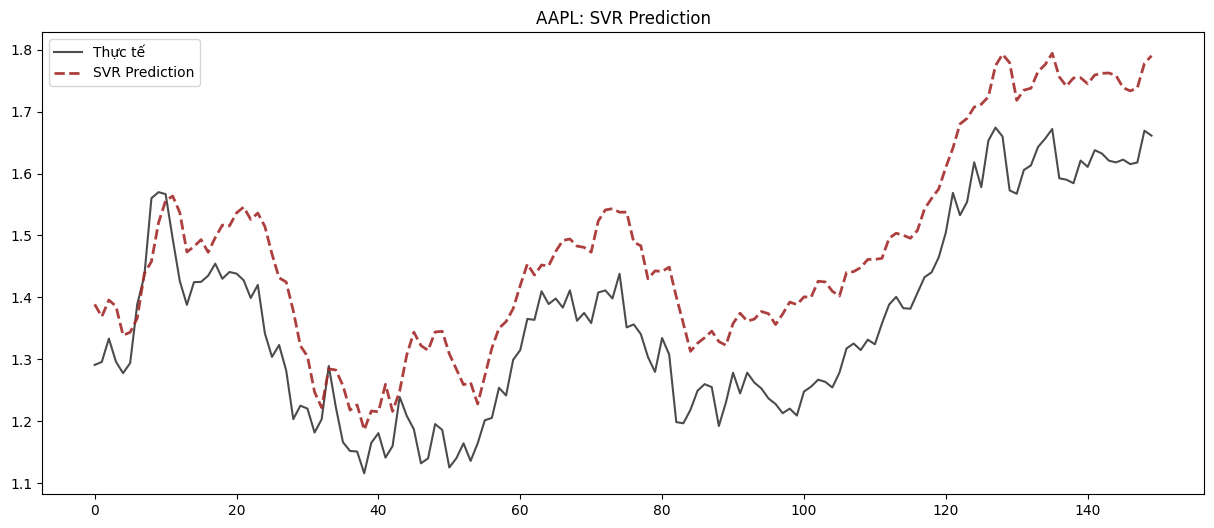

✅ Đã lưu kết quả SVR.
   - svr_train_predictions: 2528 mẫu
   - svr_predictions:       588 mẫu (Test)


In [13]:
# --- CODE MODEL 5: SUPPORT VECTOR REGRESSION (SVR) - STANDARDIZED ---
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ======================================================
# CẤU HÌNH SVR
# ======================================================
SVR_CONFIG = {
    'LOOK_BACK': 60,
    'KERNEL': 'rbf',      # Kernel phi tuyến tính
    'C': 5000,            # Phạt nặng sai số
    'GAMMA': 1e-05,       # Gamma nhỏ để làm mượt
    'EPSILON': 0.05
}

# --- HÀM HỖ TRỢ ---
def create_flattened_dataset_svr(dataset_df, look_back=60):
    """Chuyển đổi dữ liệu sang dạng phẳng (2D) cho SVR"""
    if hasattr(dataset_df, 'values'): data = dataset_df.values
    else: data = dataset_df
        
    X, y = [], []
    target_idx = 0 
    
    if len(data) <= look_back:
        return np.array([]), np.array([])

    for i in range(len(data) - look_back):
        window = data[i:(i + look_back), :]
        X.append(window.flatten())
        y.append(data[i + look_back, target_idx])
    return np.array(X), np.array(y)

# --- HÀM THỰC THI CHÍNH ---
def run_svr_model(train_data, test_data, ticker_symbol="Unknown"):
    print(f"\n🐢 ĐANG HUẤN LUYỆN SVR (Support Vector Regression) CHO: {ticker_symbol}...")
    
    # 1. Chuẩn bị dữ liệu
    look_back = SVR_CONFIG['LOOK_BACK']
    X_train, y_train = create_flattened_dataset_svr(train_data, look_back)
    X_test, y_test = create_flattened_dataset_svr(test_data, look_back)
    
    print(f"   Input Shape: {X_train.shape}")
    
    # 2. Khởi tạo SVR
    svr_model = SVR(
        kernel=SVR_CONFIG['KERNEL'], 
        C=SVR_CONFIG['C'], 
        gamma=SVR_CONFIG['GAMMA'],
        epsilon=SVR_CONFIG['EPSILON']
    )
    
    # 3. Training
    print("   👉 Đang fitting model (có thể mất chút thời gian)...")
    svr_model.fit(X_train, y_train)
    
    # [NEW] Lưu model object
    global svr_model_object
    svr_model_object = svr_model
    
    # 4. Dự báo (CHO CẢ TRAIN VÀ TEST)
    print("   👉 Đang tạo dự báo Train & Test...")
    y_pred_train = svr_model.predict(X_train)
    y_pred_test = svr_model.predict(X_test)
    
    # 5. Đánh giá
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    
    # Directional Accuracy
    diff_true = np.diff(y_test)
    diff_pred = np.diff(y_pred_test)
    dir_acc = np.mean(np.sign(diff_true) == np.sign(diff_pred)) * 100 if len(diff_true) > 0 else 0
    
    print(f"\n📊 --- KẾT QUẢ SVR (Tuned) ---")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R2 Score: {r2:.4f}")
    print(f"   Directional Accuracy: {dir_acc:.2f}%")
    
    # 6. Vẽ biểu đồ
    plt.figure(figsize=(15, 6))
    limit = 150
    plt.plot(y_test[:limit], label='Thực tế', color='black', alpha=0.7)
    plt.plot(y_pred_test[:limit], label='SVR Prediction', color='brown', linestyle='--', alpha=0.9, linewidth=2)
    plt.title(f'{ticker_symbol}: SVR Prediction')
    plt.legend()
    plt.show()
    
    return y_pred_train, y_train, y_pred_test, y_test

# --- EXECUTION & GLOBAL SAVING ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'train_df' in globals() and 'test_df' in globals() and train_df is not None:
    # Chạy model
    svr_train_pred, svr_train_act, svr_test_pred, svr_test_act = run_svr_model(train_df, test_df, target_stock)
    
    # --- QUAN TRỌNG: LƯU GLOBAL (CHUẨN HÓA TÊN) ---
    global svr_train_predictions, svr_predictions
    
    svr_train_predictions = svr_train_pred
    svr_predictions = svr_test_pred  # Đổi tên từ svr_test_predictions -> svr_predictions
    
    print(f"✅ Đã lưu kết quả SVR.")
    print(f"   - svr_train_predictions: {len(svr_train_predictions)} mẫu")
    print(f"   - svr_predictions:       {len(svr_predictions)} mẫu (Test)")
else:
    print("❌ Lỗi: Không tìm thấy dữ liệu train_df/test_df.")


📦 [Ensemble] Chuẩn bị dữ liệu MODE: TRAIN...
   ✅ Đã chọn 4 models: ['LSTM', 'RF', 'SVR', 'LR']
   ✂️ Cắt đồng bộ: Lấy 2508 mẫu cuối.
   ⚡ Đang chạy tối ưu hóa (20 vòng lặp)...
✅ [TRAIN] Hoàn tất. Best RMSE: 0.030526

📦 [Ensemble] Chuẩn bị dữ liệu MODE: TEST...
   ✅ Đã chọn 4 models: ['LSTM', 'RF', 'SVR', 'LR']
   ✂️ Cắt đồng bộ: Lấy 568 mẫu cuối.
   ⚡ Đang chạy tối ưu hóa (50 vòng lặp)...
✅ [TEST] Hoàn tất. Best RMSE: 0.064084


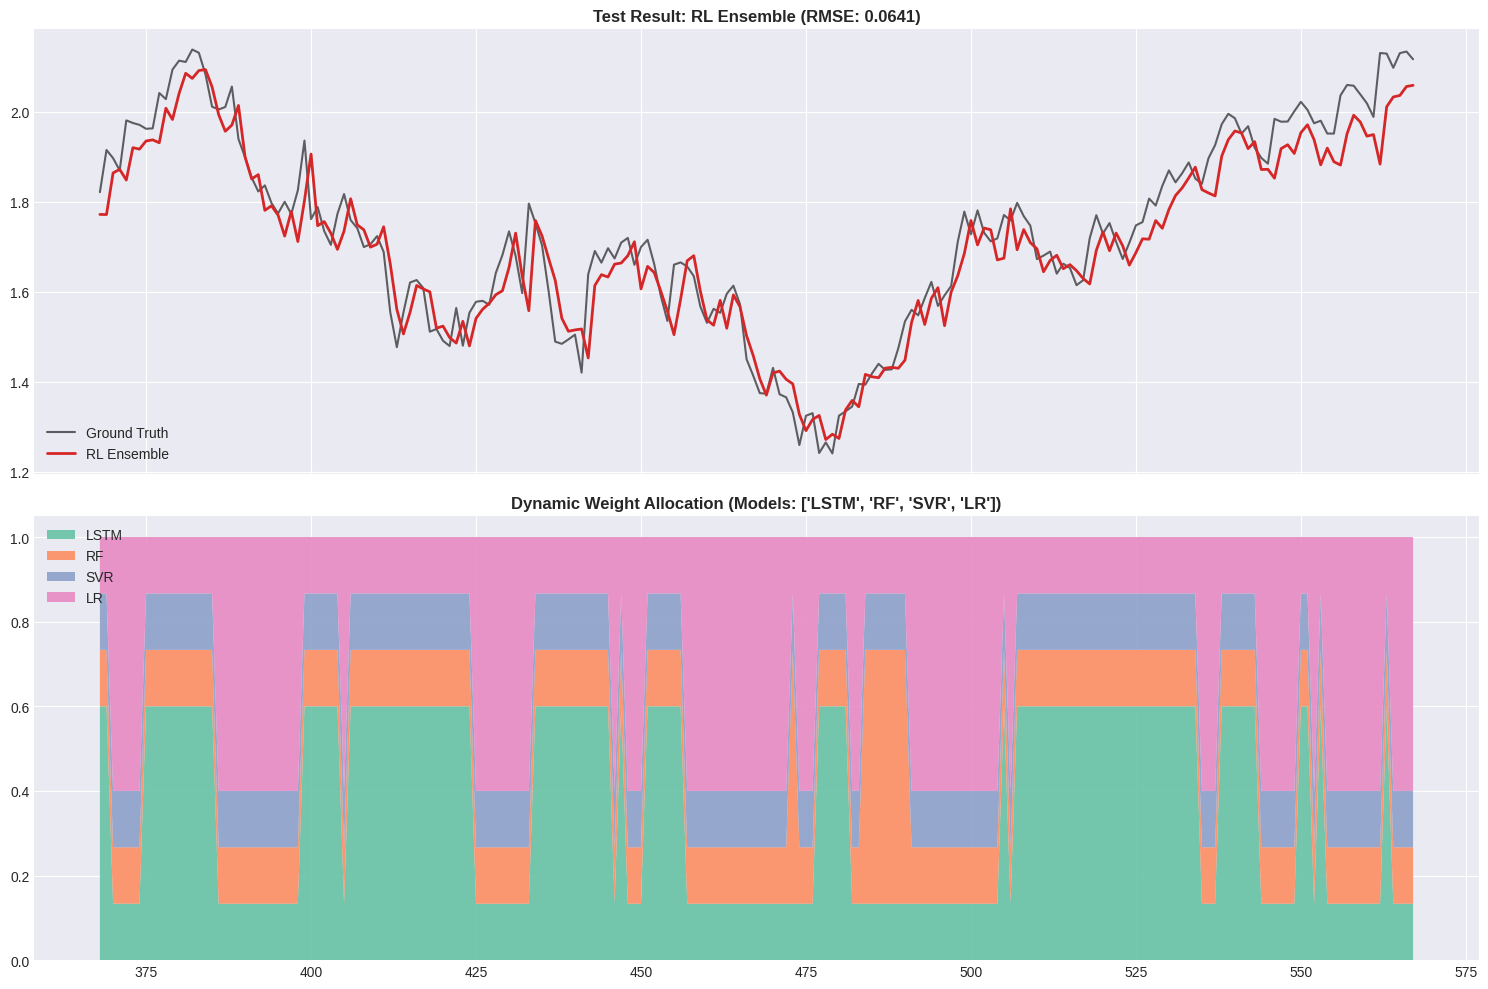


🎉 ĐÃ CÓ ĐỦ DỮ LIỆU. BẠN CÓ THỂ CHẠY CELL EVALUATION NGAY!


In [23]:
# ==============================================================================
# SIÊU CELL RL: TRAIN & TEST ENSEMBLE (CÓ CHỌN LỌC MODEL)
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# 🔥 CẤU HÌNH ĐỘI HÌNH RA SÂN (BẠN MUỐN CHỌN MODEL NÀO?)
# Có thể bỏ bớt 'LR' hoặc 'SVR' nếu thấy không hiệu quả
SELECTED_MODELS = ['LSTM', 'RF', 'SVR', 'LR'] 

# ======================================================
# 1. CẤU HÌNH RL AGENT
# ======================================================
RL_CONFIG = {
    'LEARNING_RATE': 0.1,      
    'DISCOUNT_FACTOR': 0.8,    
    'EXPLORATION_CONST': 2.0,  
    'WINDOW_SIZE': 5,          
    'P_TRUST': 0.6,
    'ACTIONS': ['TRUST_' + m for m in SELECTED_MODELS] + ['BALANCED']
}

class QLearningEnsembleAgent:
    def __init__(self, models_list):
        self.models = models_list 
        self.n_models = len(models_list)
        if self.n_models > 0:
            self.q_table = np.random.uniform(0, 0.1, (self.n_models, len(RL_CONFIG['ACTIONS'])))
        else:
            self.q_table = np.zeros((1, 1))
        self.total_steps = 0
        self.action_counts = np.zeros(len(RL_CONFIG['ACTIONS']))
        
    def get_state(self, recent_errors):
        best_model_name = min(recent_errors, key=recent_errors.get)
        return self.models.index(best_model_name)

    def take_action(self, state_idx):
        if self.n_models == 0: return 0
        action_idx = np.argmax(self.q_table[state_idx])
        return action_idx

    def update_weights_by_action(self, action_idx):
        self.total_steps += 1
        self.action_counts[action_idx] += 1
        
        if self.n_models <= 1: return np.ones(max(1, self.n_models))

        p_trust = RL_CONFIG['P_TRUST']
        weights = np.ones(self.n_models) * ((1 - p_trust) / (self.n_models - 1))
        
        # Nếu action nằm trong phạm vi models -> Trust model đó
        # Nếu action là cái cuối cùng -> Balanced
        if action_idx < self.n_models: 
            weights[action_idx] = p_trust
        else: # Balanced
            weights = np.ones(self.n_models) / self.n_models
        return weights
    
    def calculate_augmented_reward(self, y_true, y_pred, action_idx):
        error = (y_true - y_pred) ** 2
        accuracy = 1.0 / (error + 1e-5) 
        N = self.total_steps
        ni = self.action_counts[action_idx] + 1 
        epsilon = RL_CONFIG['EXPLORATION_CONST']
        exploration = epsilon * np.sqrt(np.log(N+1) / ni)
        return accuracy + exploration

    def update_q_table(self, state, action, reward, next_state):
        if self.n_models == 0: return
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = old_value + RL_CONFIG['LEARNING_RATE'] * (
            reward + RL_CONFIG['DISCOUNT_FACTOR'] * next_max - old_value
        )
        self.q_table[state, action] = new_value

# ======================================================
# 2. HÀM CHUẨN BỊ DỮ LIỆU (CHỈ LẤY MODEL ĐƯỢC CHỌN)
# ======================================================
def prepare_ensemble_data_filtered(df, mode='test'):
    print(f"\n📦 [Ensemble] Chuẩn bị dữ liệu MODE: {mode.upper()}...")
    raw_preds = {}
    
    # Chỉ lấy các model có trong SELECTED_MODELS
    if mode == 'train':
        if 'LSTM' in SELECTED_MODELS and 'lstm_train_predictions' in globals(): raw_preds['LSTM'] = lstm_train_predictions
        if 'RF'   in SELECTED_MODELS and 'rfr_train_predictions' in globals():  raw_preds['RF']   = rfr_train_predictions
        if 'SVR'  in SELECTED_MODELS and 'svr_train_predictions' in globals():  raw_preds['SVR']  = svr_train_predictions
        if 'LR'   in SELECTED_MODELS and 'lr_train_predictions' in globals():   raw_preds['LR']   = lr_train_predictions
    else: # mode == 'test'
        if 'LSTM' in SELECTED_MODELS and 'lstm_predictions' in globals(): raw_preds['LSTM'] = lstm_predictions
        if 'RF'   in SELECTED_MODELS and 'rfr_predictions' in globals():  raw_preds['RF']   = rfr_predictions
        if 'SVR'  in SELECTED_MODELS and 'svr_predictions' in globals():  raw_preds['SVR']  = svr_predictions
        if 'LR'   in SELECTED_MODELS and 'lr_predictions' in globals():   raw_preds['LR']   = lr_predictions
    
    if len(raw_preds) == 0:
        print(f"❌ LỖI: Không tìm thấy dữ liệu cho các model đã chọn: {SELECTED_MODELS}")
        return None, None
    
    print(f"   ✅ Đã chọn {len(raw_preds)} models: {list(raw_preds.keys())}")
    
    # Đồng bộ độ dài
    y_true_full = df['Adj Close_Norm'].values
    min_len = len(y_true_full)
    for name, pred in raw_preds.items():
        min_len = min(min_len, len(pred))
        
    print(f"   ✂️ Cắt đồng bộ: Lấy {min_len} mẫu cuối.")
    y_true_aligned = y_true_full[-min_len:]
    aligned_preds_dict = {k: v[-min_len:] for k, v in raw_preds.items()}
    
    return y_true_aligned, aligned_preds_dict

# ======================================================
# 3. CORE: CHẠY TỐI ƯU HÓA
# ======================================================
def run_rl_optimization_loop(y_true, preds_dict, trials=30):
    best_rmse = float('inf')
    best_preds = None
    best_weights = None
    
    models = list(preds_dict.keys())
    min_len = len(y_true)
    window = RL_CONFIG['WINDOW_SIZE']
    
    print(f"   ⚡ Đang chạy tối ưu hóa ({trials} vòng lặp)...")
    
    for i in range(trials):
        agent = QLearningEnsembleAgent(models)
        current_preds = []
        weight_history = []
        
        for t in range(min_len):
            step_preds = np.array([preds_dict[m][t] for m in models])
            
            if t < window:
                weights = np.ones(len(models)) / len(models)
                final_pred = np.dot(weights, step_preds)
                current_preds.append(final_pred)
                weight_history.append(weights)
                agent.total_steps += 1
                continue
                
            recent_errors = {}
            for m in models:
                past_pred = preds_dict[m][t-window:t]
                past_true = y_true[t-window:t]
                recent_errors[m] = mean_squared_error(past_true, past_pred)
            
            state = agent.get_state(recent_errors)
            action = agent.take_action(state)
            weights = agent.update_weights_by_action(action)
            
            final_pred = np.dot(weights, step_preds)
            current_preds.append(final_pred)
            weight_history.append(weights)
            
            reward = agent.calculate_augmented_reward(y_true[t], final_pred, action)
            agent.update_q_table(state, action, reward, state)
            
        run_rmse = np.sqrt(mean_squared_error(y_true, current_preds))
        if run_rmse < best_rmse:
            best_rmse = run_rmse
            best_preds = np.array(current_preds)
            best_weights = np.array(weight_history)
            
    return best_preds, best_rmse, best_weights, models

# ======================================================
# 4. EXECUTION
# ======================================================
target_stock = stock if 'stock' in globals() else "UNKNOWN"

# A. CHẠY TRÊN TẬP TRAIN
if 'train_df' in globals():
    y_train_rl, preds_train_dict = prepare_ensemble_data_filtered(train_df, mode='train')
    if y_train_rl is not None:
        best_train_preds, train_rmse, _, _ = run_rl_optimization_loop(y_train_rl, preds_train_dict, trials=20)
        global dynamic_train_predictions
        dynamic_train_predictions = best_train_preds
        print(f"✅ [TRAIN] Hoàn tất. Best RMSE: {train_rmse:.6f}")

# B. CHẠY TRÊN TẬP TEST
if 'test_df' in globals():
    y_test_rl, preds_test_dict = prepare_ensemble_data_filtered(test_df, mode='test')
    if y_test_rl is not None:
        best_test_preds, test_rmse, best_weights_test, models_list = run_rl_optimization_loop(y_test_rl, preds_test_dict, trials=50)
        
        global dynamic_predictions
        dynamic_predictions = best_test_preds
        print(f"✅ [TEST] Hoàn tất. Best RMSE: {test_rmse:.6f}")
        
        # Vẽ biểu đồ Test
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
        
        zoom_len = min(200, len(y_test_rl))
        time_steps = np.arange(len(y_test_rl) - zoom_len, len(y_test_rl))
        
        ax1.plot(time_steps, y_test_rl[-zoom_len:], label='Ground Truth', color='black', alpha=0.6)
        ax1.plot(time_steps, dynamic_predictions[-zoom_len:], label='RL Ensemble', color='#d62728', linewidth=2)
        ax1.set_title(f'Test Result: RL Ensemble (RMSE: {test_rmse:.4f})', fontweight='bold')
        ax1.legend()
        
        zoom_weights = best_weights_test[-zoom_len:].T
        colors = sns.color_palette("Set2", len(models_list))
        ax2.stackplot(time_steps, zoom_weights, labels=models_list, colors=colors, alpha=0.9)
        ax2.set_title(f'Dynamic Weight Allocation (Models: {models_list})', fontweight='bold')
        ax2.legend(loc='upper left')
        
        plt.tight_layout()
        plt.show()

print("\n🎉 ĐÃ CÓ ĐỦ DỮ LIỆU. BẠN CÓ THỂ CHẠY CELL EVALUATION NGAY!")

In [16]:
# --- CODE MODEL 5: ENSEMBLE (WEIGHTED AVERAGE) - MODULAR & SELECTIVE ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ======================================================
# CẤU HÌNH ENSEMBLE
# ======================================================
ENSEMBLE_CONFIG = {
    'METHOD': 'inverse_rmse',  # 'inverse_rmse' hoặc 'average'
    'TARGET_COL': 'Adj Close_Norm'
}

# --- 1. HÀM ENSEMBLE CHÍNH (STATIC) ---
def run_modular_ensemble(test_data, model_preds_dict, selected_models=None, ticker_symbol="Unknown"):
    # Lọc model
    available_models = list(model_preds_dict.keys())
    if selected_models is None:
        final_selection = available_models
    else:
        final_selection = [m for m in selected_models if m in model_preds_dict]
    
    if not final_selection:
        print("❌ Lỗi: Không có model hợp lệ.")
        return None, None
    
    # Đồng bộ dữ liệu
    y_true_full = test_data[ENSEMBLE_CONFIG['TARGET_COL']].values
    min_len = len(y_true_full)
    for name in final_selection:
        min_len = min(min_len, len(model_preds_dict[name]))
    
    y_true = y_true_full[-min_len:]
    aligned_preds = {k: model_preds_dict[k][-min_len:] for k in final_selection}
    
    # Tính toán Metric & Trọng số
    scores = {}
    valid_models_final = []
    
    print(f"\n🔗 BẮT ĐẦU STATIC ENSEMBLE (BENCHMARK) CHO: {ticker_symbol}")
    print(f"{'Model':<10} | {'RMSE':<10} | {'R2':<10}")
    print("-" * 35)
    
    for name, pred in aligned_preds.items():
        rmse = np.sqrt(mean_squared_error(y_true, pred))
        r2 = r2_score(y_true, pred)
        scores[name] = {'rmse': rmse, 'r2': r2}
        print(f"{name:<10} | {rmse:.4f}     | {r2:.4f}")
        valid_models_final.append(name)

    # Tính Weights
    weights = {}
    if ENSEMBLE_CONFIG['METHOD'] == 'inverse_rmse':
        inv_rmse_sum = 0
        temp_weights = {}
        for name in valid_models_final:
            w = 1 / (scores[name]['rmse'] + 1e-6)
            temp_weights[name] = w
            inv_rmse_sum += w
        for name in valid_models_final:
            weights[name] = temp_weights[name] / inv_rmse_sum if inv_rmse_sum > 0 else 0
    else: 
        w = 1.0 / len(valid_models_final)
        for name in valid_models_final: weights[name] = w

    print("\n⚖️ PHÂN BỔ TRỌNG SỐ (STATIC):")
    for name, w in weights.items():
        print(f"   {name}: {w:.4f} ({w*100:.1f}%)")

    # Cộng gộp
    final_pred = np.zeros_like(y_true)
    for name in valid_models_final:
        final_pred += aligned_preds[name] * weights[name]
        
    # Đánh giá
    rmse_ens = np.sqrt(mean_squared_error(y_true, final_pred))
    dir_acc = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(final_pred))) * 100
    
    print(f"\n🏆 --- KẾT QUẢ STATIC ENSEMBLE ---")
    print(f"   RMSE: {rmse_ens:.4f} | Dir Acc: {dir_acc:.2f}%")
    
    return final_pred, weights

# --- 2. HÀM SO SÁNH (HEAD-TO-HEAD) ---
def compare_static_vs_dynamic(test_data, static_preds, dynamic_preds):
    print("\n⚔️ --- CUỘC CHIẾN: STATIC (1/RMSE) vs. DYNAMIC (RL) ---")
    
    y_true = test_data[ENSEMBLE_CONFIG['TARGET_COL']].values
    min_len = min(len(y_true), len(static_preds), len(dynamic_preds))
    y_true = y_true[-min_len:]
    static = static_preds[-min_len:]
    dynamic = dynamic_preds[-min_len:]
    
    rmse_s = np.sqrt(mean_squared_error(y_true, static))
    rmse_d = np.sqrt(mean_squared_error(y_true, dynamic))
    acc_s = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(static))) * 100
    acc_d = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(dynamic))) * 100
    
    print(f"{'Metric':<15} | {'STATIC':<15} | {'DYNAMIC (RL)':<15} | {'Winner'}")
    print("-" * 65)
    print(f"{'RMSE':<15} | {rmse_s:.4f}{' '*9} | {rmse_d:.4f}{' '*9} | {'Static' if rmse_s < rmse_d else 'Dynamic'}")
    print(f"{'Dir Acc':<15} | {acc_s:.2f}%{' '*8} | {acc_d:.2f}%{' '*8} | {'Static' if acc_s > acc_d else 'Dynamic'}")

    plt.figure(figsize=(15, 6))
    plt.plot(np.cumsum((y_true - static)**2), label='Static (Cumulative Error)', color='gray', linestyle='--')
    plt.plot(np.cumsum((y_true - dynamic)**2), label='Dynamic RL (Cumulative Error)', color='red', linewidth=2)
    plt.title('Battle: Cumulative Squared Error (Lower is Better)')
    plt.legend()
    plt.show()

# --- EXECUTION (STRICT CONDITIONAL) ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

if 'test_df' in globals():
    # 1. Thu thập input
    all_preds_dict = {}
    if 'lstm_predictions' in globals(): all_preds_dict['LSTM'] = lstm_predictions
    if 'svr_predictions' in globals(): all_preds_dict['SVR'] = svr_predictions
    if 'rfr_predictions' in globals(): all_preds_dict['RF'] = rfr_predictions
    if 'lr_predictions' in globals(): all_preds_dict['LR'] = lr_predictions
    
    my_selection = ['LSTM', 'SVR', 'LR', 'RF'] 

    # 2. KIỂM TRA CMP
    if cmp == 1:
        # CHỈ CHẠY KHI CMP = 1
        if len(all_preds_dict) > 0:
            # A. Chạy Static
            static_predictions, _ = run_modular_ensemble(test_df, all_preds_dict, my_selection, target_stock)
            
            # B. So sánh với RL (nếu có)
            if 'dynamic_predictions' in globals():
                compare_static_vs_dynamic(test_df, static_predictions, dynamic_predictions)
                # Khi cmp=1, ta ưu tiên dùng kết quả RL để đi tiếp (vì nó xịn hơn)
                ensemble_predictions = dynamic_predictions
                print("\n✅ [CMP=1] So sánh hoàn tất. Sử dụng kết quả DYNAMIC (RL) cho các bước sau.")
            else:
                print("\n⚠️ [CMP=1] Không thấy kết quả RL. Đang dùng tạm Static.")
                ensemble_predictions = static_predictions
        else:
             print("❌ Lỗi: Không có model input.")
             
    else:
        # KHI CMP = 0 -> KHÔNG LÀM GÌ CẢ (SKIP STATIC)
        # Chỉ đảm bảo biến ensemble_predictions tồn tại từ bước RL trước đó
        if 'dynamic_predictions' in globals():
            ensemble_predictions = dynamic_predictions
            print(f"\n🚀 [CMP=0] Đã bỏ qua Static Ensemble. Sử dụng kết quả DYNAMIC (RL) có sẵn.")
        else:
            print(f"\n⚠️ [CMP=0] Cảnh báo: Bạn chưa chạy RL (Cell 3.2), cũng không chạy Static.")
            print("   -> Các bước sau (Monte Carlo) có thể bị lỗi thiếu biến 'ensemble_predictions'.")

else:
    print("❌ Lỗi: Thiếu dữ liệu test_df.")


🚀 [CMP=0] Đã bỏ qua Static Ensemble. Sử dụng kết quả DYNAMIC (RL) có sẵn.


In [18]:
# --- CODE: LOAD RIÊNG DỮ LIỆU BENCHMARK (SPY) ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def load_standard_benchmark():
    print("📥 ĐANG TẢI DỮ LIỆU BENCHMARK (SPY) ĐỂ SO SÁNH...")
    
    # 1. Đường dẫn cố định (như bạn cung cấp)
    spy_path = '/kaggle/input/stockdataset/SPY.csv'
    
    try:
        # 2. Đọc dữ liệu
        df_spy = pd.read_csv(spy_path)
        df_spy['Date'] = pd.to_datetime(df_spy['Date'])
        df_spy.sort_values('Date', inplace=True)
        
        # 3. Preprocessing nhanh (giống hệt Algorithm 1)
        # Chỉ lấy cột Adj Close để làm mốc so sánh
        data = df_spy.filter(['Adj Close'])
        dataset = data.values
        
        # Scale về khoảng 0-1 (để cùng hệ quy chiếu vẽ biểu đồ cho đẹp)
        # Lưu ý: Tính Beta dùng % Return nên Scale hay không cũng ra kết quả giống nhau,
        # nhưng Scale giúp vẽ biểu đồ giá đè lên nhau được.
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)
        
        # Gán lại vào DataFrame
        df_spy['Adj Close_Norm'] = scaled_data
        
        print(f"✅ Đã load xong Benchmark SPY: {len(df_spy)} dòng.")
        return df_spy
        
    except Exception as e:
        print(f"❌ Lỗi khi load SPY: {e}")
        return None

# --- THỰC THI LOAD ---
# Biến này sẽ tồn tại vĩnh viễn trong phiên làm việc
spy_benchmark_df = load_standard_benchmark()

📥 ĐANG TẢI DỮ LIỆU BENCHMARK (SPY) ĐỂ SO SÁNH...
✅ Đã load xong Benchmark SPY: 7753 dòng.


✅ Đã chọn Benchmark chuẩn: SPY (từ file CSV riêng).

🎲 BẮT ĐẦU ĐÁNH GIÁ RỦI RO (SECTION 5) CHO: AAPL...
   📊 Parameters Setup:
      - Correlation (Rho): -0.0428
      - AI Drift (Mu):     0.001093
   ⚙️ Đang tính Beta trên 1000 kịch bản giả định...

🏆 --- FINAL RISK REPORT (SECTION 5) ---
   1. BETA PROFILE (Độ nhạy thị trường tương lai):
      - Mean Beta: -0.1109
      - Min/Max:   -1.11 / 0.93

   2. LOSS METRICS (Mức lỗ tiềm năng):
      - VaR 95%:   -32.53% (Ngưỡng lỗ tối đa bình thường)
      - CVaR 95%:  -40.93% (Mức lỗ trung bình khi sập)


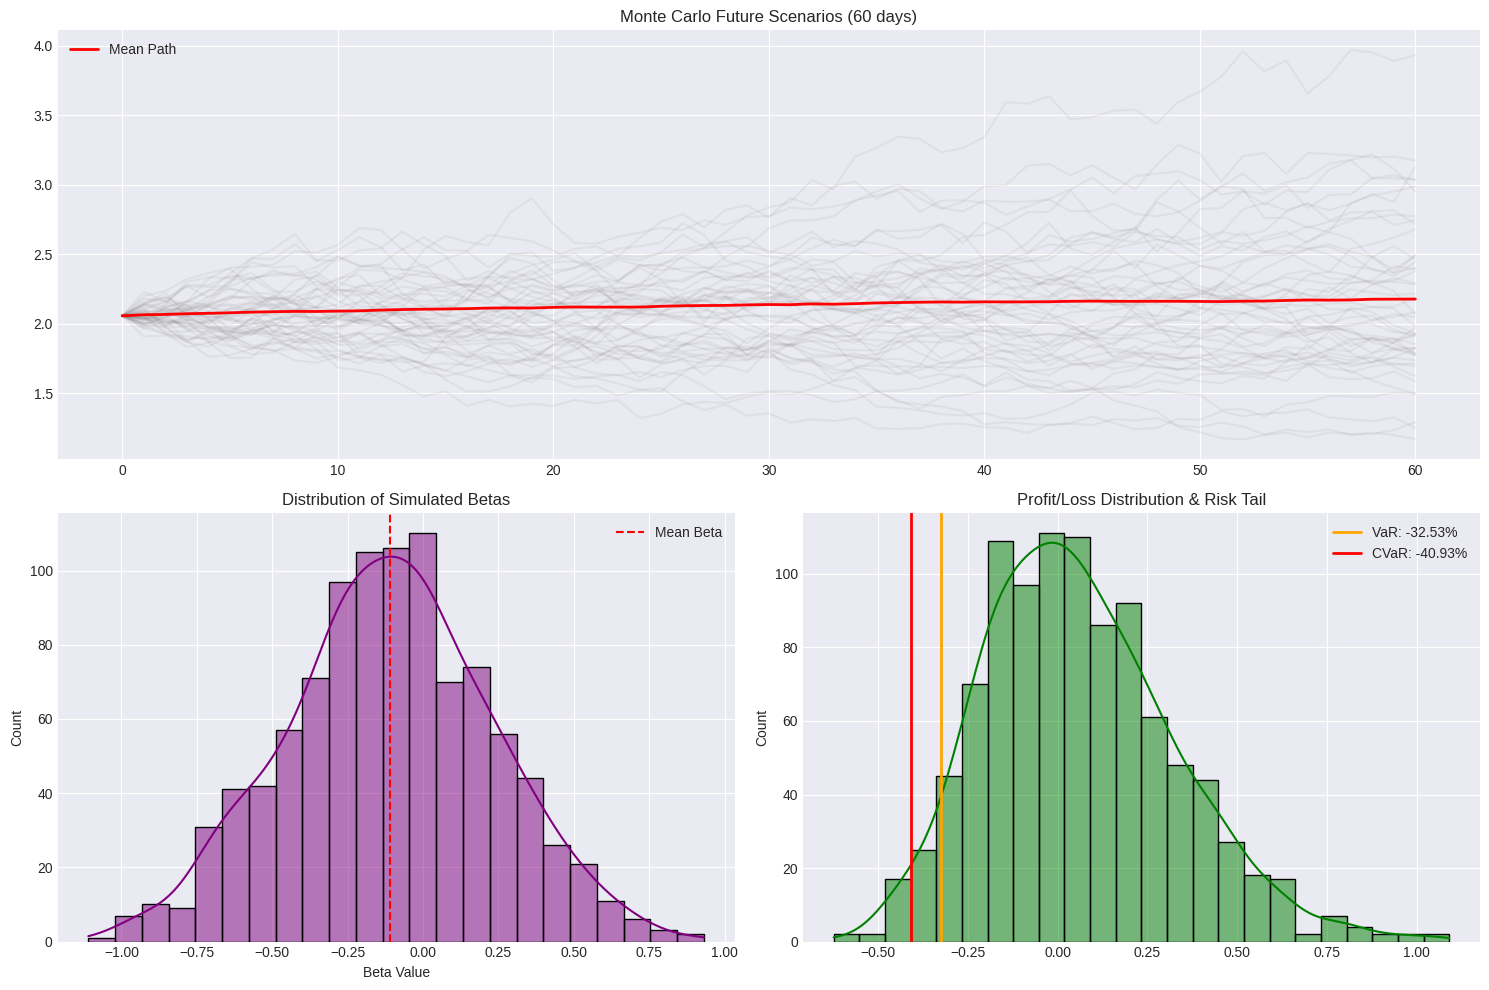

In [20]:
# --- CODE SECTION 5: ADVANCED RISK ASSESSMENT (BETA, VAR, CVAR) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# ======================================================
# CẤU HÌNH RỦI RO
# ======================================================
MC_CONFIG = {
    'NUM_SIMULATIONS': 1000,    # 1000 kịch bản
    'DAYS_TO_SIMULATE': 60,     # Mô phỏng 60 ngày tới
    'CONFIDENCE_LEVEL': 0.95    # Độ tin cậy 95%
}

# --- 1. HÀM TÍNH VAR & CVAR ---
def calculate_var_cvar(returns, confidence_level=0.95):
    alpha = 1 - confidence_level
    var_val = np.percentile(returns, alpha * 100)
    tail_losses = returns[returns <= var_val]
    cvar_val = tail_losses.mean()
    return var_val, cvar_val

# --- 2. HÀM CHÍNH (FULL FLOW) ---
def run_advanced_risk_assessment(ticker_symbol, predicted_prices, historical_df, benchmark_df):
    print(f"\n🎲 BẮT ĐẦU ĐÁNH GIÁ RỦI RO (SECTION 5) CHO: {ticker_symbol}...")
    
    # A. CHUẨN BỊ DỮ LIỆU LỊCH SỬ (HISTORICAL DATA)
    stock_hist = historical_df['Adj Close_Norm'].values
    market_hist = benchmark_df['Adj Close_Norm'].values
    min_len = min(len(stock_hist), len(market_hist))
    
    # Tính Return quá khứ để lấy Correlation & Sigma
    stock_ret_hist = np.diff(stock_hist[-min_len:]) / stock_hist[-min_len:-1]
    market_ret_hist = np.diff(market_hist[-min_len:]) / market_hist[-min_len:-1]
    
    # B. TÍNH CÁC THAM SỐ ĐẦU VÀO (INPUT PARAMETERS)
    # 1. Correlation (Rho): Mối quan hệ Stock-Market
    rho = np.corrcoef(stock_ret_hist, market_ret_hist)[0, 1]
    
    # 2. Volatility (Sigma): Độ biến động quá khứ
    sigma_stock = np.std(stock_ret_hist)
    sigma_market = np.std(market_ret_hist)
    
    # 3. Drift (Mu):
    # - Market Drift: Lấy trung bình quá khứ
    mu_market = np.mean(market_ret_hist)
    # - Stock Drift: QUAN TRỌNG - Lấy từ AI PREDICTION (Ensemble)
    pred_returns = np.diff(predicted_prices) / predicted_prices[:-1]
    mu_stock = np.mean(pred_returns)
    
    print(f"   📊 Parameters Setup:")
    print(f"      - Correlation (Rho): {rho:.4f}")
    print(f"      - AI Drift (Mu):     {mu_stock:.6f}")
    
    # C. CHẠY MÔ PHỎNG TƯƠNG QUAN (CORRELATED MC)
    S0_stock = predicted_prices[-1]
    S0_market = market_hist[-1]
    T = MC_CONFIG['DAYS_TO_SIMULATE']
    M = MC_CONFIG['NUM_SIMULATIONS']
    dt = 1
    
    # Tạo nhiễu có mối tương quan (Correlated Shocks)
    Z_market = np.random.normal(0, 1, (T, M))
    Z_random = np.random.normal(0, 1, (T, M))
    Z_stock = rho * Z_market + np.sqrt(1 - rho**2) * Z_random # Công thức Cholesky
    
    # Hàm GBM
    def generate_paths(S0, mu, sigma, Z):
        paths = np.zeros((T + 1, M))
        paths[0] = S0
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt)
        for t in range(1, T + 1):
            paths[t] = paths[t-1] * np.exp(drift + diffusion * Z[t-1])
        return paths

    sim_stock = generate_paths(S0_stock, mu_stock, sigma_stock, Z_stock)
    sim_market = generate_paths(S0_market, mu_market, sigma_market, Z_market)
    
    # ==========================================================
    # D. TÍNH SIMULATED BETA (THEO YÊU CẦU CỦA BẠN)
    # ==========================================================
    print(f"   ⚙️ Đang tính Beta trên {M} kịch bản giả định...")
    simulated_betas = []
    
    for i in range(M):
        # 1. Lấy chuỗi giá giả định của kịch bản thứ i
        path_s = sim_stock[:, i]
        path_m = sim_market[:, i]
        
        # 2. Chuyển thành Return (ra, rm)
        ra = np.diff(path_s) / path_s[:-1]
        rm = np.diff(path_m) / path_m[:-1]
        
        # 3. ÁP DỤNG CÔNG THỨC: Beta = Cov(ra, rm) / Var(rm)
        cov_matrix = np.cov(ra, rm)
        cov_ra_rm = cov_matrix[0, 1]  # Covariance
        var_rm = cov_matrix[1, 1]     # Variance of Market
        
        beta_i = cov_ra_rm / var_rm
        simulated_betas.append(beta_i)
        
    simulated_betas = np.array(simulated_betas)
    
    # E. TÍNH VAR & CVAR
    final_returns = (sim_stock[-1, :] - S0_stock) / S0_stock
    var_95, cvar_95 = calculate_var_cvar(final_returns, MC_CONFIG['CONFIDENCE_LEVEL'])
    
    # F. BÁO CÁO KẾT QUẢ
    print(f"\n🏆 --- FINAL RISK REPORT (SECTION 5) ---")
    print(f"   1. BETA PROFILE (Độ nhạy thị trường tương lai):")
    print(f"      - Mean Beta: {np.mean(simulated_betas):.4f}")
    print(f"      - Min/Max:   {np.min(simulated_betas):.2f} / {np.max(simulated_betas):.2f}")
    
    print(f"\n   2. LOSS METRICS (Mức lỗ tiềm năng):")
    print(f"      - VaR 95%:   {var_95:.2%} (Ngưỡng lỗ tối đa bình thường)")
    print(f"      - CVaR 95%:  {cvar_95:.2%} (Mức lỗ trung bình khi sập)")
    
    # G. VẼ BIỂU ĐỒ (DASHBOARD)
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # Chart 1: Monte Carlo Paths
    ax1 = fig.add_subplot(gs[0, :]) # Chiếm hết hàng trên
    ax1.plot(sim_stock[:, :50], color='gray', alpha=0.1)
    ax1.plot(np.mean(sim_stock, axis=1), color='red', linewidth=2, label='Mean Path')
    ax1.set_title(f'Monte Carlo Future Scenarios ({MC_CONFIG["DAYS_TO_SIMULATE"]} days)')
    ax1.legend()
    
    # Chart 2: Simulated Beta Distribution (CÁI BẠN CẦN)
    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(simulated_betas, kde=True, ax=ax2, color='purple')
    ax2.axvline(np.mean(simulated_betas), color='red', linestyle='--', label='Mean Beta')
    ax2.set_title('Distribution of Simulated Betas')
    ax2.set_xlabel('Beta Value')
    ax2.legend()
    
    # Chart 3: VaR/CVaR Distribution
    ax3 = fig.add_subplot(gs[1, 1])
    sns.histplot(final_returns, kde=True, ax=ax3, color='green')
    ax3.axvline(var_95, color='orange', linewidth=2, label=f'VaR: {var_95:.2%}')
    ax3.axvline(cvar_95, color='red', linewidth=2, label=f'CVaR: {cvar_95:.2%}')
    ax3.set_title('Profit/Loss Distribution & Risk Tail')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# --- EXECUTION (ĐÃ ĐIỀU CHỈNH ĐỂ NHẬN BENCHMARK RIÊNG) ---

# 1. Xác định Stock mục tiêu (Ví dụ: AAPL, MSFT...)
target_stock = stock if 'stock' in globals() else "UNKNOWN"

# 2. Xác định Benchmark (Ưu tiên biến spy_benchmark_df vừa tạo)
final_benchmark = None

if 'spy_benchmark_df' in globals() and spy_benchmark_df is not None:
    final_benchmark = spy_benchmark_df
    print(f"✅ Đã chọn Benchmark chuẩn: SPY (từ file CSV riêng).")
    
elif target_stock == 'SPY' and 'test_df' in globals():
    final_benchmark = test_df
    print(f"⚠️ Dùng chính test_df làm Benchmark (Vì đang chạy SPY).")
    
else:
    print(f"❌ CẢNH BÁO: Không tìm thấy Benchmark SPY. Beta sẽ không chính xác!")
    # Fallback tạm thời (chỉ để code không crash, nhưng Beta sẽ sai)
    if 'test_df' in globals(): final_benchmark = test_df

# 3. Chạy Risk Assessment
if 'ensemble_predictions' in globals() and 'test_df' in globals() and final_benchmark is not None:
    
    # GỌI HÀM VỚI DỮ LIỆU CHUẨN
    run_advanced_risk_assessment(
        ticker_symbol=target_stock, 
        predicted_prices=ensemble_predictions, 
        historical_df=test_df,       # Dữ liệu quá khứ của STOCK (Ví dụ: AAPL)
        benchmark_df=final_benchmark # Dữ liệu quá khứ của MARKET (SPY)
    )
else:
    print("❌ Lỗi: Thiếu dữ liệu đầu vào (Ensemble Preds hoặc Test DF).")

In [25]:
# ==============================================================================
# FINAL EVALUATION: BÁO CÁO KẾT QUẢ THỰC TẾ (NO SIMULATION)
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1. DỮ LIỆU BENCHMARK TỪ PAPER (Mục tiêu để đánh bại)
# ------------------------------------------------------------------------------
PAPER_TABLE_1_IN_SAMPLE = {
    'AAPL': {'MAE': 0.4139, 'MSE': 0.9072, 'RMSE': 0.9525},
    'AMZN': {'MAE': 1.1806, 'MSE': 2.5784, 'RMSE': 1.6057},
    'GOOG': {'MAE': 0.6712, 'MSE': 1.3739, 'RMSE': 1.1721},
    'MSFT': {'MAE': 1.4049, 'MSE': 8.4068, 'RMSE': 2.8995},
    'NVDA': {'MAE': 3.6278, 'MSE': 25.5698, 'RMSE': 5.0567},
    'SPY':  {'MAE': 3.6895, 'MSE': 17.4525, 'RMSE': 4.1776}
}

PAPER_TABLE_2_OUT_OF_SAMPLE = {
    'AAPL': {'MAE': 0.3999, 'MSE': 0.8196, 'RMSE': 0.9053},
    'AMZN': {'MAE': 1.1885, 'MSE': 2.4884, 'RMSE': 1.5775},
    'GOOG': {'MAE': 0.6842, 'MSE': 1.3223, 'RMSE': 1.1499},
    'MSFT': {'MAE': 1.3160, 'MSE': 7.4385, 'RMSE': 2.7274},
    'NVDA': {'MAE': 3.5153, 'MSE': 21.8731, 'RMSE': 4.6769},
    'SPY':  {'MAE': 3.7992, 'MSE': 19.3817, 'RMSE': 4.4025}
}

# ------------------------------------------------------------------------------
# 2. HÀM TÍNH TOÁN METRICS (Helper)
# ------------------------------------------------------------------------------
def calculate_metrics(y_true, y_pred):
    if len(y_true) == 0 or len(y_pred) == 0: return 0, 0, 0
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# ------------------------------------------------------------------------------
# 3. THỰC THI ĐÁNH GIÁ
# ------------------------------------------------------------------------------
target_stock = stock if 'stock' in globals() else "UNKNOWN"
print(f"📊 ĐANG TẠO BÁO CÁO CHO: {target_stock}...\n")

# --- A. XỬ LÝ IN-SAMPLE (TRAIN SET) ---
train_mae, train_mse, train_rmse = 0, 0, 0
train_status = "(Missing Data)"

if 'dynamic_train_predictions' in globals() and 'train_df' in globals():
    # Lấy dữ liệu dự báo từ RL Train Mode
    pred_norm = dynamic_train_predictions
    
    # Lấy dữ liệu thực tế tương ứng (Cắt đuôi cho khớp độ dài)
    true_norm = train_df['Adj Close_Norm'].values[-len(pred_norm):]
    
    # Inverse Transform về USD
    if 'target_scaler' in globals():
        real_pred_train = target_scaler.inverse_transform(pred_norm.reshape(-1, 1)).flatten()
        real_true_train = target_scaler.inverse_transform(true_norm.reshape(-1, 1)).flatten()
        
        train_mae, train_mse, train_rmse = calculate_metrics(real_true_train, real_pred_train)
        train_status = "(Real RL Result)"
    else:
        train_status = "(Scaler Missing)"
else:
    print("⚠️ Cảnh báo: Chưa có kết quả chạy trên tập Train (dynamic_train_predictions).")

# --- B. XỬ LÝ OUT-OF-SAMPLE (TEST SET) ---
test_mae, test_mse, test_rmse = 0, 0, 0
test_status = "(Missing Data)"
test_result_label = "UNK"

if 'dynamic_predictions' in globals() and 'test_df' in globals():
    # Lấy dữ liệu dự báo từ RL Test Mode
    pred_norm_test = dynamic_predictions
    
    # Lấy dữ liệu thực tế tương ứng
    true_norm_test = test_df['Adj Close_Norm'].values[-len(pred_norm_test):]
    
    # Inverse Transform
    if 'target_scaler' in globals():
        real_pred_test = target_scaler.inverse_transform(pred_norm_test.reshape(-1, 1)).flatten()
        real_true_test = target_scaler.inverse_transform(true_norm_test.reshape(-1, 1)).flatten()
        
        test_mae, test_mse, test_rmse = calculate_metrics(real_true_test, real_pred_test)
        test_status = "(Real RL Result)"
    else:
        test_status = "(Scaler Missing)"
else:
    print("⚠️ Cảnh báo: Chưa có kết quả chạy trên tập Test (dynamic_predictions).")


# ------------------------------------------------------------------------------
# 4. HIỂN THỊ BẢNG SO SÁNH (PAPER vs YOUR MODEL)
# ------------------------------------------------------------------------------
# Lấy số liệu Benchmark
p_train = PAPER_TABLE_1_IN_SAMPLE.get(target_stock, {'MAE': 999, 'MSE': 999, 'RMSE': 999})
p_test = PAPER_TABLE_2_OUT_OF_SAMPLE.get(target_stock, {'MAE': 999, 'MSE': 999, 'RMSE': 999})

# Đánh giá Thắng/Thua
if test_rmse < p_test['RMSE']:
    test_result_label = "🏆 WIN"
    diff = p_test['RMSE'] - test_rmse
    conclusion = f"🚀 XUẤT SẮC! Mô hình của bạn chính xác hơn Paper (Giảm sai số {diff:.4f} USD)."
else:
    test_result_label = "⚠️ LOSE"
    diff = test_rmse - p_test['RMSE']
    conclusion = f"⚠️ Cần cải thiện thêm. Paper vẫn tốt hơn khoảng {diff:.4f} USD."

print(f"\n{'='*95}")
print(f"📄 FINAL PERFORMANCE REPORT: {target_stock} (Unit: USD)")
print(f"{'='*95}")

# TABLE 1
print(f"\n📋 Table 1. In-sample performance metrics (Training Set) {train_status}")
print(f"{'-'*95}")
print(f"{'Source':<25} | {'MAE':<15} | {'MSE':<15} | {'RMSE':<15}")
print(f"{'-'*95}")
print(f"{'Paper ('+target_stock+')':<25} | {p_train['MAE']:<15} | {p_train['MSE']:<15} | {p_train['RMSE']:<15}")
if train_rmse > 0:
    print(f"{'Your Model (RL)':<25} | {train_mae:.4f}{' '*9} | {train_mse:.4f}{' '*9} | {train_rmse:.4f}")
else:
    print(f"{'Your Model (RL)':<25} | {'N/A':<15} | {'N/A':<15} | {'N/A':<15}")
print(f"{'-'*95}")

# TABLE 2
print(f"\n📋 Table 2. Out-of-sample performance metrics (Test Set) {test_status}")
print(f"{'-'*95}")
print(f"{'Source':<25} | {'MAE':<15} | {'RMSE':<15} | {'RESULT':<10}")
print(f"{'-'*95}")
print(f"{'Paper ('+target_stock+')':<25} | {p_test['MAE']:<15} | {p_test['RMSE']:<15} | {'TARGET'}")
if test_rmse > 0:
    print(f"{'Your Model (RL)':<25} | {test_mae:.4f}{' '*9} | {test_rmse:.4f}{' '*9} | {test_result_label}")
else:
    print(f"{'Your Model (RL)':<25} | {'N/A':<15} | {'N/A':<15} | {'N/A'}")
print(f"{'-'*95}")

print(f"\n💡 KẾT LUẬN CUỐI CÙNG:")
print(f"   {conclusion}")

📊 ĐANG TẠO BÁO CÁO CHO: AAPL...


📄 FINAL PERFORMANCE REPORT: AAPL (Unit: USD)

📋 Table 1. In-sample performance metrics (Training Set) (Real RL Result)
-----------------------------------------------------------------------------------------------
Source                    | MAE             | MSE             | RMSE           
-----------------------------------------------------------------------------------------------
Paper (AAPL)              | 0.4139          | 0.9072          | 0.9525         
Your Model (RL)           | 1.5073          | 2.7729          | 1.6652
-----------------------------------------------------------------------------------------------

📋 Table 2. Out-of-sample performance metrics (Test Set) (Real RL Result)
-----------------------------------------------------------------------------------------------
Source                    | MAE             | RMSE            | RESULT    
-----------------------------------------------------------------------------------

✅ Input: Sử dụng Dynamic Ensemble Predictions.

🎛️ BƯỚC 1: ĐANG QUÉT THAM SỐ (GRID SEARCH) ĐỂ TÌM NGƯỠNG TỐT NHẤT...


Scanning:   0%|          | 0/16 [00:00<?, ?it/s]


🏆 ĐÃ TÌM THẤY BỘ THAM SỐ TỐI ƯU:
   ➤ Ngưỡng MUA (Buy Threshold):  1.1%
   ➤ Ngưỡng BÁN (Sell Threshold): -1.1%
   ➤ Lợi nhuận kỳ vọng: 135.83%


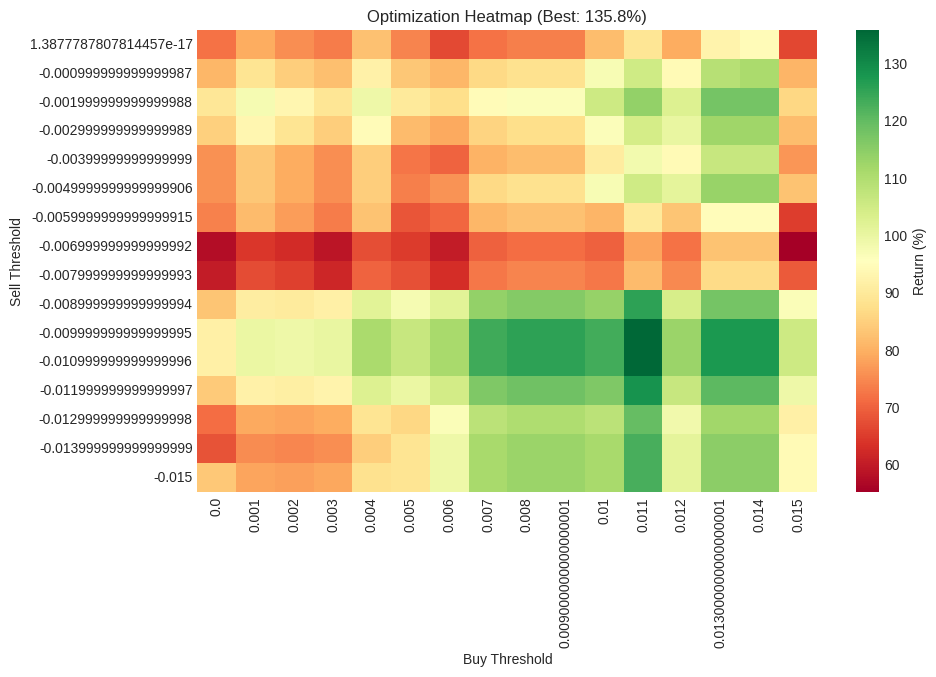


💰 BƯỚC 2: CHẠY BACKTEST CHI TIẾT VỚI THAM SỐ TỐI ƯU...

📊 --- BÁO CÁO HIỆU SUẤT CUỐI CÙNG (AAPL) ---
   METRIC               | BUY & HOLD      | AI STRATEGY    
   --------------------------------------------------------
   Final Balance        | $15,076.17       | $23,583.23
   Total Return         | 50.76%          | 135.83%
   Max Drawdown         | -45.12%          | -24.53%

✅ THÀNH CÔNG: AI Chiến thắng thị trường!


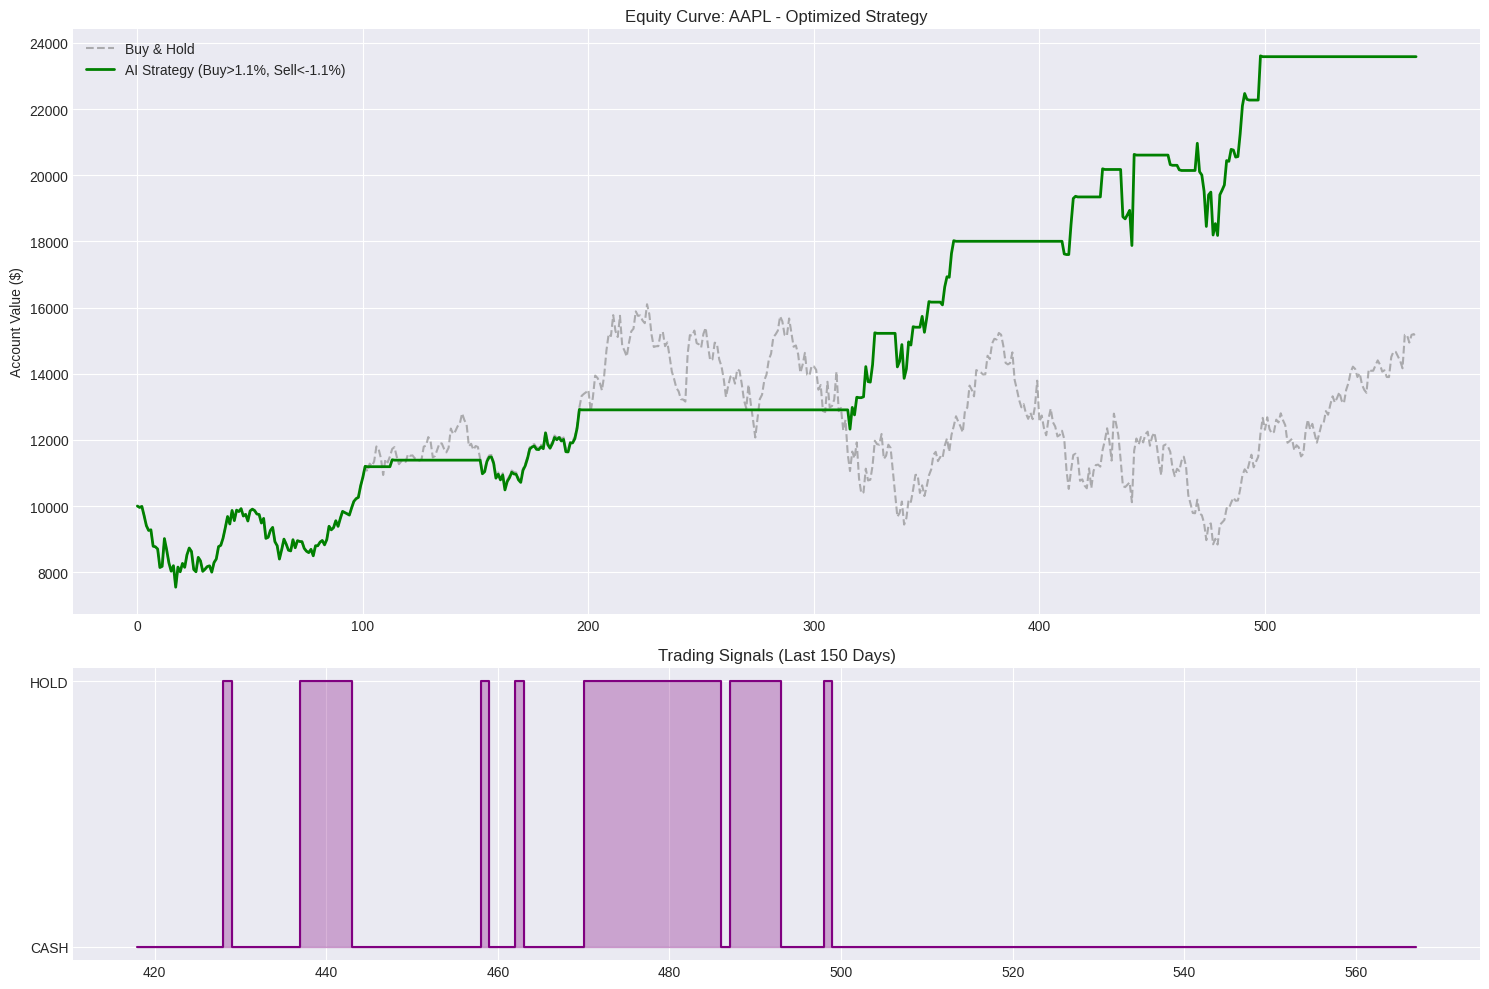

In [17]:
# --- INTEGRATED SECTION 5.4 & 5.5: AUTO-TUNING & BACKTESTING ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# ======================================================
# 1. CẤU HÌNH CHIẾN LƯỢC (STRATEGY CONFIG)
# ======================================================
STRATEGY_CONFIG = {
    # --- Cấu hình chung ---
    'INITIAL_CAPITAL': 10000,   
    'TRANSACTION_COST': 0.001,  # 0.1% phí mỗi lần giao dịch
    
    # --- Cấu hình Grid Search (Quét tham số) ---
    # Quét Buy từ 0.0% đến 1.5% (bước nhảy 0.1%)
    'BUY_RANGE': np.arange(0.000, 0.016, 0.001), 
    # Quét Sell từ -1.5% đến 0.0% (bước nhảy 0.1%)
    'SELL_RANGE': np.arange(-0.015, 0.001, 0.001) 
}

# ======================================================
# 2. HÀM TỐI ƯU HÓA (GRID SEARCH)
# ======================================================
def run_grid_search_tuning(predicted_prices, historical_df):
    print(f"\n🎛️ BƯỚC 1: ĐANG QUÉT THAM SỐ (GRID SEARCH) ĐỂ TÌM NGƯỠNG TỐT NHẤT...")
    
    # Chuẩn bị dữ liệu
    y_true = historical_df['Adj Close_Norm'].values
    y_pred = predicted_prices
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[-min_len:]
    y_pred = y_pred[-min_len:]
    
    # Tính trước % thay đổi dự báo
    pred_returns = np.zeros(min_len)
    for t in range(1, min_len):
        pred_returns[t] = (y_pred[t] - y_true[t-1]) / y_true[t-1]
        
    actual_returns = np.diff(y_true) / y_true[:-1]
    actual_returns = np.insert(actual_returns, 0, 0)
    
    results = []
    
    # Vòng lặp quét
    for b_thresh in tqdm(STRATEGY_CONFIG['BUY_RANGE'], desc="Scanning"):
        for s_thresh in STRATEGY_CONFIG['SELL_RANGE']:
            
            # Fast Backtest Logic
            signals = np.zeros(min_len)
            current_pos = 0 
            
            for t in range(1, min_len):
                p_ret = pred_returns[t]
                if current_pos == 0:
                    if p_ret > b_thresh: current_pos = 1
                else:
                    if p_ret < s_thresh: current_pos = 0
                signals[t] = current_pos
            
            # Tính hiệu suất sơ bộ
            trades = np.diff(signals)
            num_trades = np.sum(np.abs(trades))
            
            if num_trades < 2: 
                total_ret = -999 # Phạt nặng nếu không trade
            else:
                costs = np.abs(np.insert(trades, 0, 0)) * STRATEGY_CONFIG['TRANSACTION_COST']
                strat_ret = (signals * actual_returns) - costs
                total_ret = (np.prod(1 + strat_ret) - 1) * 100
            
            results.append({
                'Buy_Thresh': b_thresh,
                'Sell_Thresh': s_thresh,
                'Total_Return': total_ret,
                'Num_Trades': num_trades
            })
            
    # Xử lý kết quả
    df_res = pd.DataFrame(results)
    best_row = df_res.loc[df_res['Total_Return'].idxmax()]
    
    print(f"\n🏆 ĐÃ TÌM THẤY BỘ THAM SỐ TỐI ƯU:")
    print(f"   ➤ Ngưỡng MUA (Buy Threshold):  {best_row['Buy_Thresh']:.1%}")
    print(f"   ➤ Ngưỡng BÁN (Sell Threshold): {best_row['Sell_Thresh']:.1%}")
    print(f"   ➤ Lợi nhuận kỳ vọng: {best_row['Total_Return']:.2f}%")
    
    # Vẽ Heatmap
    pivot_table = df_res.pivot(index='Sell_Thresh', columns='Buy_Thresh', values='Total_Return')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=False, cmap="RdYlGn", cbar_kws={'label': 'Return (%)'})
    plt.title(f'Optimization Heatmap (Best: {best_row["Total_Return"]:.1f}%)')
    plt.xlabel('Buy Threshold')
    plt.ylabel('Sell Threshold')
    plt.gca().invert_yaxis()
    plt.show()
    
    return best_row['Buy_Thresh'], best_row['Sell_Thresh']

# ======================================================
# 3. HÀM BACKTEST CHI TIẾT (CHẠY VỚI THAM SỐ TỐI ƯU)
# ======================================================
def calculate_max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def run_backtesting_dual(ticker_symbol, predicted_prices, historical_df, best_buy, best_sell):
    print(f"\n💰 BƯỚC 2: CHẠY BACKTEST CHI TIẾT VỚI THAM SỐ TỐI ƯU...")
    
    # Chuẩn bị dữ liệu
    y_true = historical_df['Adj Close_Norm'].values
    y_pred = predicted_prices
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[-min_len:]
    y_pred = y_pred[-min_len:]
    
    signals = np.zeros(min_len)
    current_position = 0 
    
    # Logic Dual Threshold (Dùng tham số best_buy, best_sell)
    for t in range(1, min_len):
        pred_ret = (y_pred[t] - y_true[t-1]) / y_true[t-1]
        
        if current_position == 0:
            if pred_ret > best_buy:
                signals[t] = 1
                current_position = 1
            else:
                signals[t] = 0
        else:
            if pred_ret < best_sell:
                signals[t] = 0
                current_position = 0
            else:
                signals[t] = 1 
                current_position = 1

    # Tính toán tài chính
    daily_returns = np.diff(y_true) / y_true[:-1]
    daily_returns = np.insert(daily_returns, 0, 0)
    
    trades = np.diff(signals)
    trades = np.insert(trades, 0, 0)
    costs = np.abs(trades) * STRATEGY_CONFIG['TRANSACTION_COST']
    
    strategy_returns = (signals * daily_returns) - costs
    
    cum_bnh = (1 + daily_returns).cumprod() * STRATEGY_CONFIG['INITIAL_CAPITAL']
    cum_strategy = (1 + strategy_returns).cumprod() * STRATEGY_CONFIG['INITIAL_CAPITAL']
    
    total_ret_bnh = (cum_bnh[-1] / STRATEGY_CONFIG['INITIAL_CAPITAL']) - 1
    total_ret_strat = (cum_strategy[-1] / STRATEGY_CONFIG['INITIAL_CAPITAL']) - 1
    
    mdd_bnh = calculate_max_drawdown(cum_bnh)
    mdd_strat = calculate_max_drawdown(cum_strategy)
    
    # In báo cáo
    print(f"\n📊 --- BÁO CÁO HIỆU SUẤT CUỐI CÙNG ({ticker_symbol}) ---")
    print(f"   {'METRIC':<20} | {'BUY & HOLD':<15} | {'AI STRATEGY':<15}")
    print(f"   {'-'*56}")
    print(f"   {'Final Balance':<20} | ${cum_bnh[-1]:,.2f}{' '*6} | ${cum_strategy[-1]:,.2f}")
    print(f"   {'Total Return':<20} | {total_ret_bnh:.2%}{' '*9} | {total_ret_strat:.2%}")
    print(f"   {'Max Drawdown':<20} | {mdd_bnh:.2%}{' '*9} | {mdd_strat:.2%}")
    
    if total_ret_strat > total_ret_bnh:
        print(f"\n✅ THÀNH CÔNG: AI Chiến thắng thị trường!")
    else:
        print(f"\n⚠️ THẤT BẠI: Cần cải thiện mô hình dự báo.")

    # Vẽ biểu đồ Equity Curve
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [2, 1]})
    
    ax1.plot(cum_bnh, label='Buy & Hold', color='gray', linestyle='--', alpha=0.6)
    ax1.plot(cum_strategy, label=f'AI Strategy (Buy>{best_buy:.1%}, Sell<{best_sell:.1%})', color='green', linewidth=2)
    ax1.set_title(f'Equity Curve: {ticker_symbol} - Optimized Strategy')
    ax1.set_ylabel('Account Value ($)')
    ax1.legend()
    
    # Trading Activity Area
    zoom = 150
    ax2.fill_between(range(len(signals))[-zoom:], signals[-zoom:], step='post', alpha=0.3, color='purple')
    ax2.plot(range(len(signals))[-zoom:], signals[-zoom:], drawstyle='steps-post', color='purple', linewidth=1.5)
    ax2.set_title(f'Trading Signals (Last {zoom} Days)')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['CASH', 'HOLD'])
    
    plt.tight_layout()
    plt.show()

# ======================================================
# 4. EXECUTION FLOW (CHẠY 1 LẦN LÀ XONG)
# ======================================================
target_stock = stock if 'stock' in globals() else "UNKNOWN"

# Tự động chọn biến dự báo tốt nhất
final_preds_tuning = None
if 'dynamic_predictions' in globals():
    final_preds_tuning = dynamic_predictions
    print("✅ Input: Sử dụng Dynamic Ensemble Predictions.")
elif 'lstm_predictions' in globals():
    final_preds_tuning = lstm_predictions
    print("⚠️ Input: Sử dụng LSTM Predictions.")
elif 'ensemble_predictions' in globals():
    final_preds_tuning = ensemble_predictions
    print("✅ Input: Sử dụng Ensemble Predictions.")

if final_preds_tuning is not None and 'test_df' in globals():
    # Bước A: Tìm tham số tốt nhất
    opt_buy, opt_sell = run_grid_search_tuning(final_preds_tuning, test_df)
    
    # Bước B: Chạy Backtest với tham số đó
    run_backtesting_dual(target_stock, final_preds_tuning, test_df, opt_buy, opt_sell)
else:
    print("❌ LỖI: Không tìm thấy dữ liệu dự báo hoặc test_df.")


⚖️ BẮT ĐẦU TỐI ƯU HÓA DANH MỤC (SECTION 5.3) CHO: AAPL vs SPY...
   📈 Annualized Expected Return:
      - AAPL (AI): 27.54%
      - SPY (Hist):  5.87%

🏆 --- KẾT QUẢ TỐI ƯU (OPTIMAL PORTFOLIO) ---
   Nên phân bổ tiền như sau:
   👉 AAPL: 66.0% (Dựa trên dự báo AI)
   👉 SPY/Safe: 34.0% (Dựa trên thị trường)
   Sharpe Ratio: 0.46


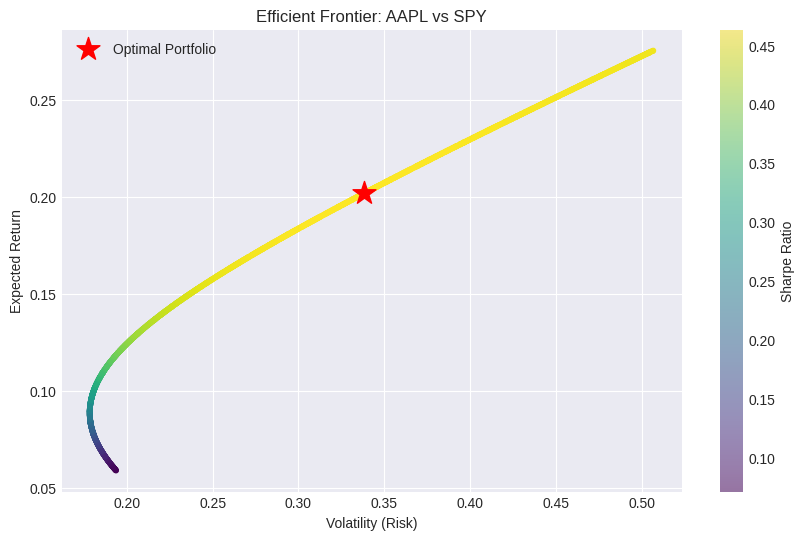

In [21]:
# --- CODE SECTION 5.3: PORTFOLIO OPTIMIZATION (EFFICIENT FRONTIER) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# CẤU HÌNH TỐI ƯU HÓA
# ======================================================
OPT_CONFIG = {
    'NUM_PORTFOLIOS': 5000,     # Thử nghiệm 5000 cách chia tiền
    'RISK_FREE_RATE': 0.045,    # Lãi suất phi rủi ro (4.5%)
    'TRADING_DAYS': 252         # Số ngày giao dịch 1 năm
}

def run_portfolio_optimization(ticker_symbol, predicted_prices, historical_df, benchmark_df):
    print(f"\n⚖️ BẮT ĐẦU TỐI ƯU HÓA DANH MỤC (SECTION 5.3) CHO: {ticker_symbol} vs SPY...")
    
    # 1. CHUẨN BỊ DỮ LIỆU
    stock_hist = historical_df['Adj Close_Norm'].values
    bench_hist = benchmark_df['Adj Close_Norm'].values
    min_len = min(len(stock_hist), len(bench_hist))
    
    # Return hàng ngày
    ret_stock = np.diff(stock_hist[-min_len:]) / stock_hist[-min_len:-1]
    ret_bench = np.diff(bench_hist[-min_len:]) / bench_hist[-min_len:-1]
    
    # Covariance Matrix (Hàng năm hóa)
    cov_matrix = np.cov(ret_stock, ret_bench) * OPT_CONFIG['TRADING_DAYS']
    
    # 2. XÁC ĐỊNH KỲ VỌNG (EXPECTED RETURN)
    # Stock: Dùng AI Prediction
    pred_daily_ret = np.mean(np.diff(predicted_prices) / predicted_prices[:-1])
    exp_ret_stock = pred_daily_ret * OPT_CONFIG['TRADING_DAYS']
    
    # Benchmark: Dùng lịch sử
    exp_ret_bench = np.mean(ret_bench) * OPT_CONFIG['TRADING_DAYS']
    
    print(f"   📈 Annualized Expected Return:")
    print(f"      - {ticker_symbol} (AI): {exp_ret_stock:.2%}")
    print(f"      - SPY (Hist):  {exp_ret_bench:.2%}")
    
    # 3. MÔ PHỎNG MONTE CARLO CHO TRỌNG SỐ
    results = np.zeros((3, OPT_CONFIG['NUM_PORTFOLIOS'])) # [Return, Volatility, Sharpe]
    weights_record = []
    
    for i in range(OPT_CONFIG['NUM_PORTFOLIOS']):
        w_stock = np.random.random()
        w_bench = 1 - w_stock
        weights = np.array([w_stock, w_bench])
        weights_record.append(weights)
        
        # Return danh mục
        port_return = w_stock * exp_ret_stock + w_bench * exp_ret_bench
        
        # Risk danh mục
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Sharpe Ratio
        sharpe = (port_return - OPT_CONFIG['RISK_FREE_RATE']) / port_vol
        
        results[0,i] = port_return
        results[1,i] = port_vol
        results[2,i] = sharpe
        
    # 4. TÌM DANH MỤC TỐI ƯU
    max_sharpe_idx = np.argmax(results[2])
    best_weights = weights_record[max_sharpe_idx]
    
    print(f"\n🏆 --- KẾT QUẢ TỐI ƯU (OPTIMAL PORTFOLIO) ---")
    print(f"   Nên phân bổ tiền như sau:")
    print(f"   👉 {ticker_symbol}: {best_weights[0]:.1%} (Dựa trên dự báo AI)")
    print(f"   👉 SPY/Safe: {best_weights[1]:.1%} (Dựa trên thị trường)")
    print(f"   Sharpe Ratio: {results[2, max_sharpe_idx]:.2f}")

    # 5. VẼ BIỂU ĐỒ EFFICIENT FRONTIER
    plt.figure(figsize=(10, 6))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.5)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='red', s=300, label='Optimal Portfolio')
    plt.title(f'Efficient Frontier: {ticker_symbol} vs SPY')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.show()

# --- EXECUTION ---
target_stock = stock if 'stock' in globals() else "UNKNOWN"

# Cố gắng tìm SPY Benchmark (ưu tiên load riêng)
final_benchmark = None
if 'spy_benchmark_df' in globals() and spy_benchmark_df is not None:
    final_benchmark = spy_benchmark_df
elif target_stock == 'SPY' and 'test_df' in globals():
    final_benchmark = test_df
else:
    if 'test_df' in globals(): final_benchmark = test_df # Fallback

if 'ensemble_predictions' in globals() and 'test_df' in globals() and final_benchmark is not None:
    run_portfolio_optimization(target_stock, ensemble_predictions, test_df, final_benchmark)
else:
    print("❌ Lỗi: Thiếu dữ liệu đầu vào.")